# Prediction notebook

This notebook allows replicating the figures and showcase how predictions can be made from the trained networks.

# Library loading and additional function definition

In [2]:
# (c) Charles Le Losq 2021
# see embedded licence file

%matplotlib inline

# dataframes and arrays
import pandas as pd 
import numpy as np
import seaborn as sns

# for plotting
import matplotlib.pyplot as plt 
import matplotlib, mpltern, corner
from mpltern.ternary.datasets import get_spiral
from matplotlib.patches import ArrowStyle, FancyArrowPatch
from matplotlib.patches import Circle, Wedge, Polygon
from matplotlib.collections import PatchCollection
import matplotlib.gridspec as gridspec
from matplotlib.gridspec import GridSpec
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.ticker import MultipleLocator, AutoMinorLocator
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.image as mpimg

# spearman corr coef
from scipy.stats import spearmanr

# mse
from sklearn.metrics import mean_squared_error

# neuravi internals
import neuravi

# other essentials
import torch, time, h5py

# we will work on CPU there
device = torch.device('cpu') #get_default_device()
print(device)


cpu


# Load dataset

In [3]:
path_data = "./data/DataSet_0p20val.hdf5"
path_raman = "./data/NKAS_Raman.hdf5"
path_density = "./data/NKAS_density.hdf5"
path_optical = "./data/NKAS_optical.hdf5"
path_liquidus = "./data/NKAS_liquidus.hdf5"

ds = neuravi.data_loader(path_data,path_raman,path_density,path_optical,path_liquidus,device)


# Function to bag models

This object will help bagging results from the 10 best models and calling their predictions.

In [4]:
class models:
    """custom global model predictions

    """
    def __init__(self, path, name_models, device):
        
        self.device = device
        self.n_models = len(name_models)
        self.models = [None for _ in range(self.n_models)]
        
        for i in range(self.n_models):
            name = name_models[i]
            
            # Extract arch
            nb_layers = int(name[name.find("l")+1:name.find("_n")])
            nb_neurons = int(name[name.find("n")+1:name.rfind("_p")])
            p_drop = float(name[name.find("p")+1:name.rfind(".")])
            
            self.models[i] = neuravi.model(4,nb_neurons,nb_layers,ds.nb_channels_raman,p_drop=p_drop) 
            self.models[i].load_state_dict(torch.load(path+name,map_location='cpu'))
            self.models[i].eval()
            
    def predict(self,method,X, T=[1000.0], lbd= [500.0]):
        
        X = torch.Tensor(X).to(self.device)
        T = torch.Tensor(T).to(self.device)
        lbd = torch.Tensor(lbd).to(self.device)
        
        if method == "raman_pred":    
            out = np.zeros((len(X),850,self.n_models)) # problem is defined with a X raman shift of 850 values
            for i in range(self.n_models):
                out[:,:,i] = getattr(self.models[i],method)(X).cpu().detach().numpy()
            return out
        else:
            out = np.zeros((len(X),self.n_models))
            
        if method in frozenset(('ag', 'myega', 'am', 'cg', 'tvf')):
            for i in range(self.n_models):
                out[:,i] = getattr(self.models[i],method)(X,T).cpu().detach().numpy().reshape(-1)
        elif method == "sellmeier":
            for i in range(self.n_models):
                out[:,i] = getattr(self.models[i],method)(X,lbd).cpu().detach().numpy().reshape(-1)           
        else:
            for i in range(self.n_models):
                out[:,i] = getattr(self.models[i],method)(X).cpu().detach().numpy().reshape(-1)
        
        return out
                    

# Loading the models

In [5]:
path = "./model/best/"
name_list = pd.read_csv("./model/best/best_list.csv").loc[:,"name"]
neuralmodel = models(path, name_list, device)

# Root-mean-squared-errors calculations

Between all datasets and their predictions.

In [6]:
criterion = torch.nn.MSELoss()

y_ag_train = neuralmodel.predict("ag",ds.x_visco_train,ds.T_visco_train)
y_ag_valid = neuralmodel.predict("ag",ds.x_visco_valid,ds.T_visco_valid)
y_ag_test = neuralmodel.predict("ag",ds.x_visco_test,ds.T_visco_test)

y_tvf_train = neuralmodel.predict("tvf",ds.x_visco_train,ds.T_visco_train)
y_tvf_valid = neuralmodel.predict("tvf",ds.x_visco_valid,ds.T_visco_valid)
y_tvf_test = neuralmodel.predict("tvf",ds.x_visco_test,ds.T_visco_test)

y_myega_train = neuralmodel.predict("myega",ds.x_visco_train,ds.T_visco_train)
y_myega_valid = neuralmodel.predict("myega",ds.x_visco_valid,ds.T_visco_valid)
y_myega_test = neuralmodel.predict("myega",ds.x_visco_test,ds.T_visco_test)

y_am_train = neuralmodel.predict("am",ds.x_visco_train,ds.T_visco_train)
y_am_valid = neuralmodel.predict("am",ds.x_visco_valid,ds.T_visco_valid)
y_am_test = neuralmodel.predict("am",ds.x_visco_test,ds.T_visco_test)

y_cg_train = neuralmodel.predict("cg",ds.x_visco_train,ds.T_visco_train)
y_cg_valid = neuralmodel.predict("cg",ds.x_visco_valid,ds.T_visco_valid)
y_cg_test = neuralmodel.predict("cg",ds.x_visco_test,ds.T_visco_test)

ag_after_train = np.sqrt(mean_squared_error(y_ag_train.mean(axis=1), ds.y_visco_train.detach().numpy()))
ag_after_valid = np.sqrt(mean_squared_error(y_ag_valid.mean(axis=1), ds.y_visco_valid.detach().numpy()))
ag_after_test = np.sqrt(mean_squared_error(y_ag_test.mean(axis=1), ds.y_visco_test.detach().numpy()))

print('AG train loss after training {0:.2f}'.format(ag_after_train))
print('AG valid loss after training {0:.2f}'.format(ag_after_valid))
print('AG test loss after training {0:.2f}'.format(ag_after_test))
print('')

tvf_after_train = np.sqrt(mean_squared_error(y_tvf_train.mean(axis=1), ds.y_visco_train.detach().numpy()))
tvf_after_valid = np.sqrt(mean_squared_error(y_tvf_valid.mean(axis=1), ds.y_visco_valid.detach().numpy()))
tvf_after_test  = np.sqrt(mean_squared_error(y_tvf_test.mean(axis=1), ds.y_visco_test.detach().numpy()))

print('TVF train loss after training {0:.2f}'.format(tvf_after_train))
print('TVF valid loss after training {0:.2f}'.format(tvf_after_valid))
print('TVF test loss after training {0:.2f}'.format(tvf_after_test))
print('')

myega_after_train = np.sqrt(mean_squared_error(y_myega_train.mean(axis=1), ds.y_visco_train.detach().numpy()))
myega_after_valid = np.sqrt(mean_squared_error(y_myega_valid.mean(axis=1), ds.y_visco_valid.detach().numpy()))
myega_after_test = np.sqrt(mean_squared_error(y_myega_test.mean(axis=1), ds.y_visco_test.detach().numpy()))

print('myega train loss after training {0:.2f}'.format(myega_after_train))
print('myega valid loss after training {0:.2f}'.format(myega_after_valid))
print('myega test loss after training {0:.2f}'.format(myega_after_test))
print('')

am_after_train = np.sqrt(mean_squared_error(y_am_train.mean(axis=1), ds.y_visco_train.detach().numpy()))
am_after_valid = np.sqrt(mean_squared_error(y_am_valid.mean(axis=1), ds.y_visco_valid.detach().numpy()))
am_after_test = np.sqrt(mean_squared_error(y_am_test.mean(axis=1), ds.y_visco_test.detach().numpy()))

print('am train loss after training {0:.2f}'.format(am_after_train))
print('am valid loss after training {0:.2f}'.format(am_after_valid))
print('am test loss after training {0:.2f}'.format(am_after_test))
print('')

cg_after_train = np.sqrt(mean_squared_error(y_cg_train.mean(axis=1), ds.y_visco_train.detach().numpy()))
cg_after_valid = np.sqrt(mean_squared_error(y_cg_valid.mean(axis=1), ds.y_visco_valid.detach().numpy()))
cg_after_test = np.sqrt(mean_squared_error(y_cg_test.mean(axis=1), ds.y_visco_test.detach().numpy()))

print('cg train loss after training {0:.2f}'.format(cg_after_train))
print('cg valid loss after training {0:.2f}'.format(cg_after_valid))
print('cg test loss after training {0:.2f}'.format(cg_after_test))
print('')

#
# Predictions for Raman spectra
#

# our real x axis, for resampling
x_raman_shift = np.arange(400.,1250.,1.0)

raman_train_predictions = neuralmodel.predict("raman_pred",ds.x_raman_train).mean(axis=2)
raman_valid_predictions = neuralmodel.predict("raman_pred",ds.x_raman_valid).mean(axis=2)


# Now we calculate on density and refractive index
ese_density_train = np.sqrt(mean_squared_error(ds.y_density_train.cpu().detach().numpy(),
                           neuralmodel.predict("density",ds.x_density_train).mean(axis=1)))
ese_density_valid = np.sqrt(mean_squared_error(ds.y_density_valid.cpu().detach().numpy(),
                           neuralmodel.predict("density",ds.x_density_valid).mean(axis=1)))
ese_density_test = np.sqrt(mean_squared_error(ds.y_density_test.cpu().detach().numpy(),
                           neuralmodel.predict("density",ds.x_density_test).mean(axis=1)))

ese_ri_train = np.sqrt(mean_squared_error(ds.y_ri_train.cpu().detach().numpy(),
                           neuralmodel.predict("sellmeier",ds.x_ri_train,lbd=ds.lbd_ri_train).mean(axis=1)))
ese_ri_valid = np.sqrt(mean_squared_error(ds.y_ri_valid.cpu().detach().numpy(),
                           neuralmodel.predict("sellmeier",ds.x_ri_valid,lbd=ds.lbd_ri_valid).mean(axis=1)))
ese_ri_test = np.sqrt(mean_squared_error(ds.y_ri_test.cpu().detach().numpy(),
                           neuralmodel.predict("sellmeier",ds.x_ri_test,lbd=ds.lbd_ri_test).mean(axis=1)))

print('density train loss after training {0:.3f}'.format(ese_density_train))
print('density valid loss after training {0:.3f}'.format(ese_density_valid))
print('density test loss after training {0:.3f}'.format(ese_density_test))
print('')

print('refractive index train loss after training {0:.3f}'.format(ese_ri_train))
print('refractive index valid loss after training {0:.3f}'.format(ese_ri_valid))
print('refractive index test loss after training {0:.3f}'.format(ese_ri_test))
print('')


AG train loss after training 0.34
AG valid loss after training 0.22
AG test loss after training 0.35

TVF train loss after training 0.40
TVF valid loss after training 0.25
TVF test loss after training 0.38

myega train loss after training 0.38
myega valid loss after training 0.26
myega test loss after training 0.36

am train loss after training 0.35
am valid loss after training 0.24
am test loss after training 0.35

cg train loss after training 0.49
cg valid loss after training 0.24
cg test loss after training 0.35

density train loss after training 0.041
density valid loss after training 0.048
density test loss after training 0.050

refractive index train loss after training 0.003
refractive index valid loss after training 0.003
refractive index test loss after training 0.005



# Figure 4

This figure presents the deep learning model, viscosity predictions for melts with ~66 mol% silica and different Al/Si ratios, and Raman spectra predictions.

/home/charles/anaconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:174: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
/home/charles/anaconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:175: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.


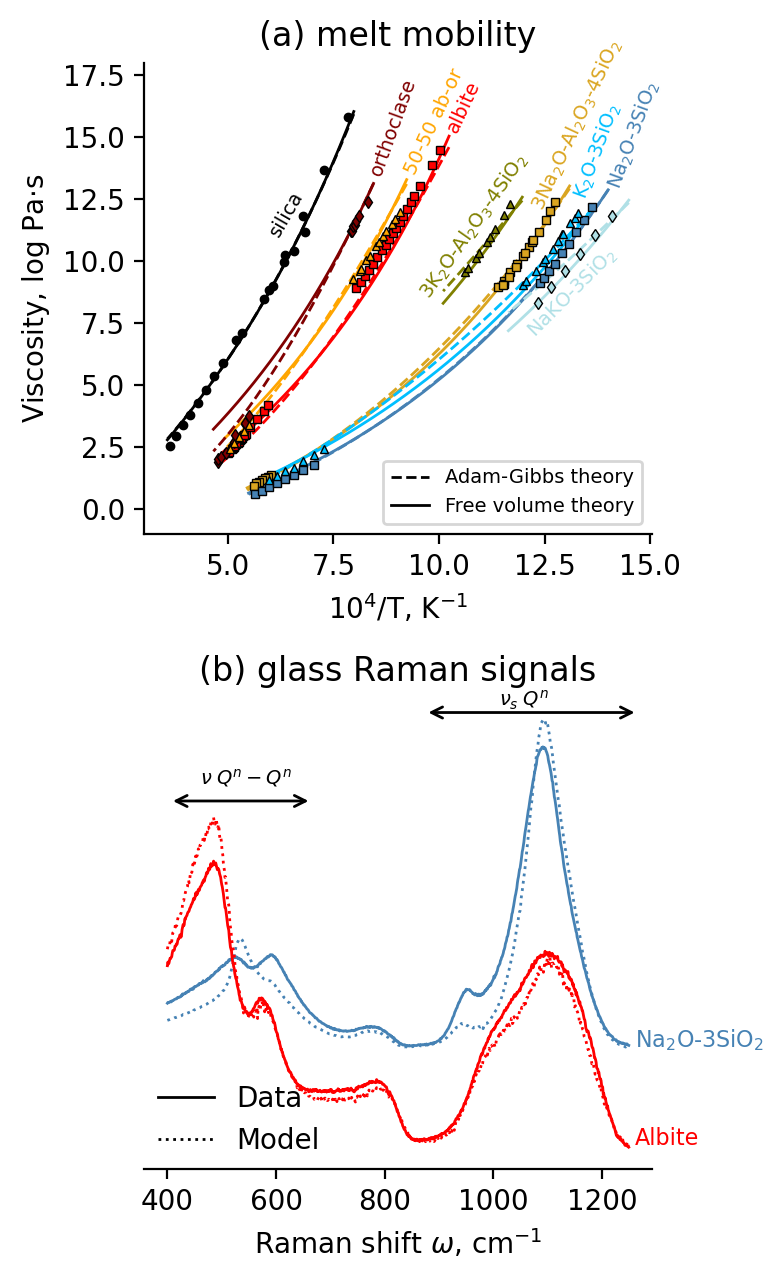

In [7]:
#
# For simplicity, data were saved in an external file
# we load it below
#
df2 = pd.read_excel("./data/Database_IPGP.xlsx",sheet_name="VISCO")
silica = df2.loc[df2.Name=="SiO2",:].reset_index()
NS3 = df2.loc[df2.Name=="NS75",:].reset_index()
KS3 = df2.loc[df2.Name=="KS75",:].reset_index()
NKS3 = df2.loc[df2.Name=="NKS75_11",:].reset_index()
Ab = df2.loc[df2.Name=="NAK75_12_0",:].reset_index()
Or = df2.loc[df2.Name=="NAK75_12_12",:].reset_index()
AbOr = df2.loc[df2.Name=="NAK75_12_6",:].reset_index()
NAS = df2.loc[df2.Name=="NA65_9",:].reset_index()
KAS = df2.loc[df2.Name=="KA65_9",:].reset_index()

#
# We define utility functions to do the figure below
#
def plot_viscocurve(ax,dts,method = "ag",color="k",marker="s",linestyle="-"):
    """plot viscosity predictions given some arguments"""
    x_inter = np.arange(dts.loc[:,"T"].min()-20,dts.loc[:,"T"].max()+50,1.0)
    if dts.loc[0,"sio2"] > 1:
        ax.plot(10000/x_inter,
                 neuralmodel.predict(method,
                                     torch.Tensor(dts.loc[0,"sio2":"k2o"].values.astype('float')*np.ones((len(x_inter),4))/100).to(device),
                                     torch.Tensor(x_inter.reshape(-1,1)).to(device)).mean(axis=1),
                color=color, linestyle=linestyle, linewidth=1,
            )
    else:
        ax.plot(10000/x_inter,
                 neuralmodel.predict(method,
                                     torch.Tensor(dts.loc[0,"sio2":"k2o"].values.astype('float')*np.ones((len(x_inter),4))).to(device),
                                     torch.Tensor(x_inter.reshape(-1,1)).to(device)).mean(axis=1),
                color=color, linestyle=linestyle, linewidth=1,
            )
    return ax

#
# The following is not used and only kept for documentation. It allows performing a 3D plot
#
def prepare_data_fig2(neuralmodel,sio2,al2o3,alkalis, xk_ = np.arange(0,1,0.01), T_ = np.arange(650,2000,1.0)):
    """prepare xk mapping for surface plot of figure 3"""
    xk_plot = []
    T_plot = []
    for count,value in enumerate(xk_):
        X__ = np.vstack([sio2*np.ones(len(T_)),
                         al2o3*np.ones(len(T_)),
                         alkalis*(1-value*np.ones(len(T_))),
                         alkalis*value*np.ones(len(T_))]).T
        if count == 0:
            xk_plot = value*np.ones(len(T_))
            T_plot = T_.copy()
            n_plot = neuralmodel.predict("cg",X__,np.array(T_).reshape(-1,1)).mean(axis=-1)
        else:
            xk_plot = np.vstack((xk_plot,value*np.ones(len(T_))))
            T_plot = np.vstack((T_plot,T_))
            n_plot = np.vstack((n_plot,neuralmodel.predict("ag",X__,np.array(T_).reshape(-1,1)).mean(axis=-1)))
    
    return xk_plot, T_plot, n_plot

#
# now we prepare the different datasets
# this is useful if one wants to visualize the 3D plot below and can be commented if not, as it is slow.
#
#xk_plot_NKS, T_plot_NKS, n_plot_NKS  = prepare_data_fig2(neuralmodel,0.67,0.0,0.33)
#xk_plot_Jad, T_plot_Jad, n_plot_Jad = prepare_data_fig2(neuralmodel,0.67,0.165,0.165,T_ = np.arange(1050,2000,1.0))
#xk_plot_6509, T_plot_6509, n_plot_6509 = prepare_data_fig2(neuralmodel,0.66,0.09,0.25,T_ = np.arange(750,2000,1.0))

### 
### FIGURE 4 GENERATION
###

fig1 = plt.figure(figsize=(4,6.5),dpi=200)

gs = GridSpec(2, 1, figure=fig1)
#ax1 = fig.add_subplot(gs[0, :])

ax = fig1.add_subplot(gs[0, 0])
ax2 = fig1.add_subplot(gs[1, 0])

#
# colors
#
colors = {'NS66':'steelblue',
          'KS66':'deepskyblue',
          'NKS66':'powderblue',
          'SiO2':'black',
          'albite':'red',
          'AbOr':'orange',
          'orthoclase':'maroon',
          'NA65_9':'goldenrod',
          'KA65_9':'olive',
          'mec1':'black',
          'mec2':'black'}
mew=0.5

#
# for the dummy legend
#
ax.plot([],[],"k--",lw=1,label="Adam-Gibbs theory")
ax.plot([],[],"k-",lw=1,label="Free volume theory")
ax.legend(loc="lower right", fontsize=7)

#
# data
#

plot_viscocurve(ax, Ab,method = "cg",color=colors['albite'])
plot_viscocurve(ax, AbOr,method = "cg",color=colors['AbOr'])
plot_viscocurve(ax, Or,method = "cg",color=colors['orthoclase'])
plot_viscocurve(ax, Ab,method = "ag",linestyle="--",color=colors['albite'])
plot_viscocurve(ax, AbOr,method = "ag",linestyle="--",color=colors['AbOr'])
plot_viscocurve(ax, Or,method = "ag",linestyle="--",color=colors['orthoclase'])

plot_viscocurve(ax, NAS,method = "ag",linestyle="--",color=colors['NA65_9'])
plot_viscocurve(ax, KAS,method = "ag",linestyle="--",color=colors['KA65_9'])
plot_viscocurve(ax, NAS,method = "cg",linestyle="-",color=colors['NA65_9'])
plot_viscocurve(ax, KAS,method = "cg",linestyle="-",color=colors['KA65_9'])

plot_viscocurve(ax, silica,method = "cg",color=colors['SiO2'])
plot_viscocurve(ax, NS3,method = "cg",color=colors['NS66'])
plot_viscocurve(ax, NKS3,method = "cg",color=colors['NKS66'])
plot_viscocurve(ax, KS3,method = "cg",color=colors['KS66'])
plot_viscocurve(ax, silica,method = "ag",linestyle="--",color=colors['SiO2'])
plot_viscocurve(ax, NS3,method = "ag",linestyle="--",color=colors['NS66'])
plot_viscocurve(ax, NKS3,method = "ag",linestyle="--",color=colors['NKS66'])
plot_viscocurve(ax, KS3,method = "ag",linestyle="--",color=colors['KS66'])

markersize=3

ax.plot(10000/Ab.loc[:,"T"],Ab.viscosity,"s",ms=markersize,mec=colors['mec1'],mew=mew,color=colors['albite'])
ax.plot(10000/Or.loc[:,"T"],Or.viscosity,"d",ms=markersize,mec=colors['mec1'],mew=mew,color=colors['orthoclase'])
ax.plot(10000/AbOr.loc[:,"T"],AbOr.viscosity,"^",ms=markersize,mec=colors['mec1'],mew=mew,color=colors['AbOr'])
ax.plot(10000/NAS.loc[:,"T"],NAS.viscosity,
        "s",ms=markersize,mec=colors['mec1'],mew=mew,color=colors['NA65_9'])
ax.plot(10000/KAS.loc[:,"T"],KAS.viscosity,
        "^",ms=markersize,mec=colors['mec1'],mew=mew,color=colors['KA65_9'])

ax.plot(10000/silica.loc[:,"T"],silica.viscosity,"o",ms=markersize,mec=colors['mec1'],mew=mew,color=colors['SiO2'])
ax.plot(10000/NS3.loc[:,"T"],NS3.viscosity,"s",ms=markersize,mec=colors['mec1'],mew=mew,color=colors['NS66'])
ax.plot(10000/NKS3.loc[:,"T"],NKS3.viscosity,"d",ms=markersize,mec=colors['mec1'],mew=mew,color=colors['NKS66'])
ax.plot(10000/KS3.loc[:,"T"],KS3.viscosity,"^",ms=markersize,mec=colors['mec1'],mew=mew,color=colors['KS66'])



#
# Top subplot
#



# axes labels
ax.set_ylabel("Viscosity, log Pa$\cdot$s")
ax.set_xlabel("$10^4$/T, K$^{-1}$")

# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

#
# Plot Raman
#
# Albite in position 6 in raman_valid
# NS3 in position 2

ax2.plot(x_raman_shift,raman_valid_predictions[5,:]+0.3,"-",color=colors["NS66"],linewidth=1)
ax2.plot(x_raman_shift,ds.y_raman_valid.detach().numpy()[5,:]+0.3,":",color=colors["NS66"],linewidth=1)

ax2.plot(x_raman_shift,raman_valid_predictions[6,:],"-",color=colors["albite"],linewidth=1)
ax2.plot(x_raman_shift,ds.y_raman_valid.detach().numpy()[6,:],":",color=colors["albite"],linewidth=1)

#ax2.fill_betweenx([0,1.05],400,670,alpha=0.2)
#ax2.fill_betweenx([0,1.3],860,1270,alpha=0.2)
ax2.annotate(s='', xy=(870,1.32), xytext=(1270,1.32), arrowprops=dict(arrowstyle='<->'))
ax2.annotate(s='', xy=(400,1.05), xytext=(670,1.05), arrowprops=dict(arrowstyle='<->'))

ax2.annotate(r"$\nu \; Q^{n}-Q^{n}$",xy = (460,1.10),xycoords="data",fontsize=7)
ax2.annotate(r"$\nu_s \; Q^{n}$",xy = (1010,1.34),xycoords="data",fontsize=7)
#ax2.annotate(r"$R_{Raman} =$", 
#             xy=(0.45,0.65),xycoords="axes fraction",fontsize=7, ha="center")
#ax2.annotate(r"$\frac{\int_\omega \nu (Si,Al)-O-(Si,Al)}{\int_\omega \nu (Si-Al)-O}$", 
#             xy=(0.45,0.58),xycoords="axes fraction",fontsize=7, ha="center")

ax2.annotate("Albite",xy=(1260,0.0),color=colors["albite"],fontsize=8)
ax2.annotate("Na$_2$O-3SiO$_2$",xy=(1260,0.3),color=colors["NS66"],fontsize=8)
# ax2.annotate("Dotted lines = model\nSolid lines = data",xy=(0.0,0.05),xycoords="axes fraction",fontsize=7)
ax2.plot([],[],'k-',lw=1,label="Data")
ax2.plot([],[],'k:',lw=1,label="Model")
ax2.legend(borderpad=0,frameon=False,loc='lower left')

# Hide the right and top spines
ax2.spines['right'].set_visible(False)
ax2.spines['left'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax2.set_yticks([])

ax2.set_xlabel("Raman shift $\omega$, cm$^{-1}$")

# annotations
ax.set_title("(a) melt mobility")
ax2.set_title("(b) glass Raman signals")

# set axes
ax.set_ylim(-1,18)

#
# Annotations on plot of viscosity
#

ax.annotate("silica",xy=(5.9,11.0), xycoords="data", fontsize=7, rotation=60, color="black")
ax.annotate("orthoclase",xy=(8.3,13.5), xycoords="data", fontsize=7, rotation=70, color=colors['orthoclase'])
ax.annotate("albite",xy=(10.1,15.2), xycoords="data", fontsize=7, rotation=65, color=colors['albite'])
ax.annotate("50-50 ab-or",xy=(9.1,13.5), xycoords="data", fontsize=7, rotation=65, color=colors['AbOr'])
ax.annotate("3Na$_2$O-Al$_2$O$_3$-4SiO$_2$", xy=(12.1,12.1), xycoords="data", fontsize=7, rotation=65, color=colors['NA65_9'])
ax.annotate("3K$_2$O-Al$_2$O$_3$-4SiO$_2$", xy=(9.45,8.5), xycoords="data", fontsize=7, rotation=55, color=colors['KA65_9'])
ax.annotate("Na$_2$O-3SiO$_2$",xy=(13.9,13.), xycoords="data", fontsize=7, rotation=70, color= colors['NS66'])
ax.annotate("K$_2$O-3SiO$_2$",xy=(13.1,12.6), xycoords="data", fontsize=7, rotation=70, color= colors['KS66'])
ax.annotate("NaKO-3SiO$_2$",xy=(12.,6.95), xycoords="data", fontsize=7, rotation=45, color= colors['NKS66'])

plt.tight_layout()

plt.savefig("./figures/Figure4_examples.pdf")

# Figure 5: comparison of viscosity predictions from all equations

This cell generates the code for the figure that compares measurements and predictions (from the 5 equations) for viscosity.

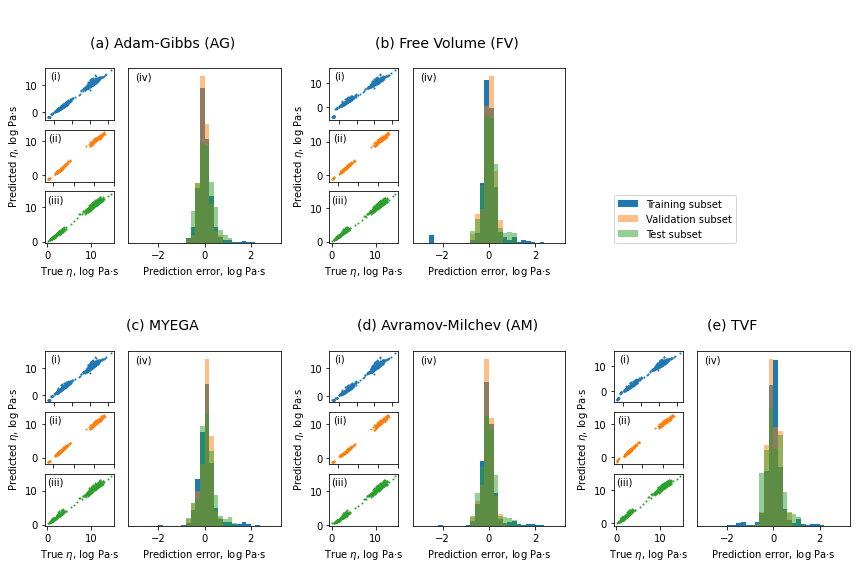

In [8]:
fig = plt.figure(figsize=(12,8))
gs = fig.add_gridspec(2,3)
sgs = gs[0,0].subgridspec(3,3)

def plot_panel(fig,gs,targets,results,title=''):
    c1 = 'C0'
    c2 = 'C1'
    c3 = 'C2'
    bins = np.linspace(-3,3,31)
    sgs = gs.subgridspec(4,3)
    ax = fig.add_subplot(sgs[1:4,1:3])
    n,b,h1 = ax.hist(results[0]-targets[0],bins,density=True,color=c1)
    n,b,h2 = ax.hist(results[1]-targets[1],bins,density=True,alpha=0.5,color=c2)
    n,b,h3 = ax.hist(results[2]-targets[2],bins,density=True,alpha=0.5,color=c3)
    ax.set_xlabel("Prediction error, log Pa$\cdot$s")
    ax.set_yticks([])
    ax.text(0.1,0.95,'(iv)',transform=ax.transAxes,va='center',ha='center')
    ax = fig.add_subplot(sgs[1,0])
    ax.scatter(targets[0],results[0],s=1,color=c1)
    ax.set_xticks([0,5,10,15])
    ax.set_xticklabels([])

    ax.text(0.15,0.85,'(i)',transform=ax.transAxes,va='center',ha='center')
    ax = fig.add_subplot(sgs[2,0])
    ax.scatter(targets[1],results[1],s=1,color=c2)
    ax.set_xticks([0,5,10,15])
    ax.set_xticklabels([])
    ax.text(0.15,0.85,'(ii)',transform=ax.transAxes,va='center',ha='center')
    ax.set_ylabel('Predicted $\eta$, log Pa$\cdot$s')
    ax = fig.add_subplot(sgs[3,0])
    ax.scatter(targets[2],results[2],s=1,color=c3)
    ax.text(0.15,0.85,'(iii)',transform=ax.transAxes,va='center',ha='center')
    ax.set_xlabel('True $\eta$, log Pa$\cdot$s')
    ax = fig.add_subplot(sgs[0,:])
    ax.text(0.5,0.3,title,va='center',ha='center',fontsize=14)
    ax.set_frame_on(False)
    ax.set_xticks([])
    ax.set_yticks([])
    
    return sgs,h1,h2,h3
plot_panel(fig,gs[0,0],[ds.y_visco_train.cpu().detach().numpy().flatten(),
                        ds.y_visco_valid.cpu().detach().numpy().flatten(),
                        ds.y_visco_test.cpu().detach().numpy().flatten()],
                       [y_ag_train.mean(axis=1),
                        y_ag_valid.mean(axis=1),
                        y_ag_test.mean(axis=1)],"(a) Adam-Gibbs (AG)")

plot_panel(fig,gs[0,1],[ds.y_visco_train.cpu().detach().numpy().flatten(),
                        ds.y_visco_valid.cpu().detach().numpy().flatten(),
                        ds.y_visco_test.cpu().detach().numpy().flatten()],
                       [y_cg_train.mean(axis=1),
                        y_cg_valid.mean(axis=1),
                        y_cg_test.mean(axis=1)],"(b) Free Volume (FV)")

plot_panel(fig,gs[1,0],[ds.y_visco_train.cpu().detach().numpy().flatten(),
                        ds.y_visco_valid.cpu().detach().numpy().flatten(),
                        ds.y_visco_test.cpu().detach().numpy().flatten()],
                       [y_myega_train.mean(axis=1),
                        y_myega_valid.mean(axis=1),
                        y_myega_test.mean(axis=1)],"(c) MYEGA")

plot_panel(fig,gs[1,1],[ds.y_visco_train.cpu().detach().numpy().flatten(),
                        ds.y_visco_valid.cpu().detach().numpy().flatten(),
                        ds.y_visco_test.cpu().detach().numpy().flatten()],
                       [y_am_train.mean(axis=1),
                        y_am_valid.mean(axis=1),
                        y_am_test.mean(axis=1)],"(d) Avramov-Milchev (AM)")

sgs,h1,h2,h3 = plot_panel(fig,gs[1,2],[ds.y_visco_train.cpu().detach().numpy().flatten(),
                        ds.y_visco_valid.cpu().detach().numpy().flatten(),
                        ds.y_visco_test.cpu().detach().numpy().flatten()],
                       [y_tvf_train.mean(axis=1),
                        y_tvf_valid.mean(axis=1),
                        y_tvf_test.mean(axis=1)],"(e) TVF")
ax = fig.add_subplot(gs[0,2])
ax.legend([h1[0],h2[0],h3[0]],['Training subset','Validation subset','Test subset'],loc=(0.,0.))
ax.set_frame_on(False)
ax.set_xticks([])
ax.set_yticks([])
plt.tight_layout()

plt.savefig("./figures/Figure5_compvisco.pdf")

# NEW OBSERVATION GENERATION

## Raman spectra

The code below allows us to predict Raman spectra corresponding to those in the training and validation.

We generate a figure comparing predictions and observations.

Least-Absolute Deviations are also calculated, as well as the R_Raman parameters.

Median of the Relative Least Absolute Deviation on Train Raman dataset is 18.71%
Median of the Relative Least Absolute Deviation on Valid Raman dataset is 14.11%
Relavive LAD on Training R_Raman: 15.20
Relavive LAD on Validation R_Raman: 13.46


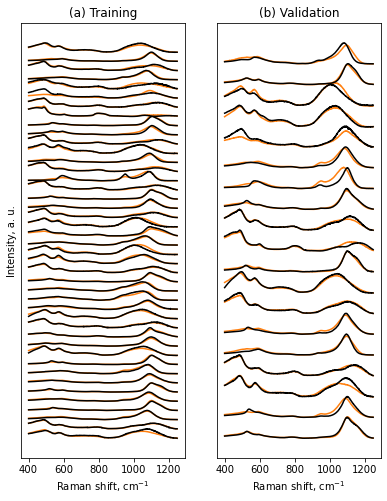

In [9]:
#
# Figure comparing Raman data to predictions
#

plt.figure(figsize=(6.44,8))

plt.subplot(1,2,1)
plt.title("(a) Training")
Raman_error_train = np.zeros(ds.x_raman_train.shape[0])
shift = 0.
for i in range(ds.x_raman_train.shape[0]):
    Raman_error_train[i] = np.mean(np.abs(raman_train_predictions[i,:]-ds.y_raman_train[i,:].detach().numpy())/raman_train_predictions[i,:])
    plt.plot(x_raman_shift,raman_train_predictions[i,:]+shift,color="C1")
    plt.plot(x_raman_shift,ds.y_raman_train[i,:].detach().numpy()+shift,"k-")
    shift += 1.
plt.xlabel("Raman shift, cm$^{-1}$")
plt.ylabel("Intensity, a. u.")
plt.yticks([])

print("Median of the Relative Least Absolute Deviation on Train Raman dataset is {0:.2f}%".format(np.median(Raman_error_train)*100))

plt.subplot(1,2,2)
plt.title("(b) Validation")
Raman_error_valid = np.zeros(ds.x_raman_valid.shape[0])
shift = 0.
for i in range(ds.x_raman_valid.shape[0]):
    Raman_error_valid[i] = np.mean(np.abs(raman_valid_predictions[i,:]-ds.y_raman_valid[i,:].detach().numpy())/raman_valid_predictions[i,:])
    plt.plot(x_raman_shift,raman_valid_predictions[i,:]+shift,color="C1")
    plt.plot(x_raman_shift,ds.y_raman_valid[i,:].detach().numpy()+shift,"k-")
    shift += 1.

plt.yticks([])
    
plt.xlabel("Raman shift, cm$^{-1}$")

print("Median of the Relative Least Absolute Deviation on Valid Raman dataset is {0:.2f}%".format(np.median(Raman_error_valid)*100))

#
# Calculating the R_Raman
#

Rr_train = np.trapz(ds.y_raman_train.detach().numpy()[:,x_raman_shift<670],x_raman_shift[x_raman_shift<670],axis=1)/np.trapz(ds.y_raman_train.detach().numpy()[:,x_raman_shift>860],x_raman_shift[x_raman_shift>860],axis=1)
Rr_valid = np.trapz(ds.y_raman_valid.detach().numpy()[:,x_raman_shift<670],x_raman_shift[x_raman_shift<670],axis=1)/np.trapz(ds.y_raman_valid.detach().numpy()[:,x_raman_shift>860],x_raman_shift[x_raman_shift>860],axis=1)

Rr_train_pred = np.trapz(raman_train_predictions[:,x_raman_shift<670],x_raman_shift[x_raman_shift<670],axis=1)/np.trapz(raman_train_predictions[:,x_raman_shift>860],x_raman_shift[x_raman_shift>860],axis=1)
Rr_valid_pred = np.trapz(raman_valid_predictions[:,x_raman_shift<670],x_raman_shift[x_raman_shift<670],axis=1)/np.trapz(raman_valid_predictions[:,x_raman_shift>860],x_raman_shift[x_raman_shift>860],axis=1)

print('Relavive LAD on Training R_Raman: {:.2f}'.format(100*np.mean(np.abs(Rr_train-Rr_train_pred)/Rr_train)))
print('Relavive LAD on Validation R_Raman: {:.2f}'.format(100*np.mean(np.abs(Rr_valid-Rr_valid_pred)/Rr_valid_pred)))

## SAMPLING THE CHEMICAL SYSTEM

Below we generate the necessary data to map various properties, like the configurational entropy, in the entire glass-forming domain of the Na2O-K2O-Al2O3-SiO2 system.

In practice, we generate many different random Na2O-K2O-Al2O3-SiO2 compositions. With 10000 data or more, this allows drawing accurate maps.

In [10]:
#
# random composition generation
#
nb_samples = 10000

sio2_gen = np.random.random_sample(nb_samples)*0.6 + 0.4
reminder = 1.0 - sio2_gen
R_MAl = np.random.random_sample(nb_samples)#*(1.0-0.4) + 0.4 # ratio of alkalis to Al
al2o3_gen = (1.0 - R_MAl)*reminder
na2o_gen = 1 - sio2_gen - al2o3_gen
k2o_gen = 1 - sio2_gen - al2o3_gen

X_gen_NAS = pd.DataFrame()
X_gen_NAS["sio2"] = sio2_gen
X_gen_NAS["al2o3"] = al2o3_gen
X_gen_NAS["na2o"] = na2o_gen
X_gen_NAS["k2o"] = 0.0
X_gen_NAS_rec = X_gen_NAS.copy()

X_gen_KAS = X_gen_NAS.copy()
X_gen_KAS["k2o"] = k2o_gen
X_gen_KAS["na2o"] = 0.0
X_gen_KAS_rec = X_gen_KAS.copy()

frames = [X_gen_NAS_rec, X_gen_KAS_rec]

X_gen_NAS = torch.Tensor(X_gen_NAS.values).to(device)
X_gen_KAS = torch.Tensor(X_gen_KAS.values).to(device)
X_gen_all = torch.Tensor(pd.concat(frames).values).to(device)

cart_NAS = neuravi.bary2cart(X_gen_NAS_rec.loc[:,["na2o","sio2","al2o3"]].values, corners=np.array([[0,0],[1,1],[2,0]]))
cart_KAS = neuravi.bary2cart(X_gen_KAS_rec.loc[:,["k2o","sio2","al2o3"]].values, corners=np.array([[0,0],[1,1],[2,0]]))

#
# For entropy map during mixing
#

def generate_compo(sio2,R_MAl):
    
    xk = np.linspace(0.,1.,500)

    master_df = pd.DataFrame()
    master_df['sio2'] = sio2[0]*np.ones(500)
    reminder = 1 - master_df['sio2']
    master_df['al2o3'] = R_MAl * reminder
    alkalis = 1 - master_df['sio2'] - master_df['al2o3']
    master_df['na2o'] = (1-xk)*alkalis
    master_df['k2o'] = xk*alkalis
    master_df['xk'] = xk
    
    for i in range(1,len(sio2)):
        ddd = pd.DataFrame()
        ddd['sio2'] = sio2[i]*np.ones(500)
        reminder = 1 - ddd['sio2']
        ddd['al2o3'] = R_MAl * reminder
        alkalis = 1 - ddd['sio2'] - ddd['al2o3']
        ddd['na2o'] = (1-xk)*alkalis
        ddd['k2o'] = xk*alkalis
        ddd['xk'] = xk
        
        master_df = pd.concat([master_df,ddd])
        
    return master_df
        
sio2_gen = np.arange(0.5,0.999,0.005)

X_gen_RS_Xk_rec = generate_compo(sio2_gen, 0.0)
X_gen_R3_Xk_rec = generate_compo(sio2_gen, 0.25)
X_gen_R2_Xk_rec = generate_compo(sio2_gen, 0.4)
X_gen_R1_Xk_rec = generate_compo(sio2_gen, 0.5)

# Correlations between melt/glass parameters and latent variables

To do that, we generate 10,000 random compositions, make predictions of several parameters, and look at the relationship between them.

In [11]:
#
# number of samples
#

nb_samples = 10000

#
# Generating the random compositions in the delimited ternary diagram
#

sio2_gen = np.random.random_sample(nb_samples)*0.5 + 0.5

reminder = 1.0 - sio2_gen

R_MAl = np.random.random_sample(nb_samples)*(1.0-0.4) + 0.4 # ratio of alkalis to Al

R_XK = np.random.random_sample(nb_samples) # ratio K/(K+Na)

al2o3_gen = (1.0 - R_MAl)*reminder

reminder = 1 - sio2_gen - al2o3_gen

na2o_gen = reminder*(1.0-R_XK)
k2o_gen = 1 - sio2_gen - al2o3_gen - na2o_gen

X_gen = pd.DataFrame()
X_gen["sio2"] = sio2_gen
X_gen["al2o3"] = al2o3_gen
X_gen["na2o"] = na2o_gen
X_gen["k2o"] = k2o_gen
M_glass = sio2_gen*60.08 + al2o3_gen*101.96 + na2o_gen*61.9789 + k2o_gen*94.2
X_rec = X_gen.copy() # this is to have a copy (non-torch, pandas)
X_gen = torch.Tensor(X_gen.values).to(device)

#
# Making predictions
#

Raman_gen = neuralmodel.predict("raman_pred",X_gen).mean(axis=2)

Rr_gen = np.trapz(Raman_gen[:,x_raman_shift<670],x_raman_shift[x_raman_shift<670],axis=1)/np.trapz(Raman_gen[:,x_raman_shift>860],x_raman_shift[x_raman_shift>860],axis=1)

# all parameters

samples = np.concatenate((neuralmodel.predict("a_tvf",X_gen).mean(axis=1).reshape(-1,1),
                          neuralmodel.predict("a_am",X_gen).mean(axis=1).reshape(-1,1),
                          neuralmodel.predict("ae",X_gen).mean(axis=1).reshape(-1,1),
                          neuralmodel.predict("a_cg",X_gen).mean(axis=1).reshape(-1,1),
                          neuralmodel.predict("b_tvf",X_gen).mean(axis=1).reshape(-1,1),
                          neuralmodel.predict("be",X_gen).mean(axis=1).reshape(-1,1),
                          neuralmodel.predict("b_cg",X_gen).mean(axis=1).reshape(-1,1),
                          neuralmodel.predict("c_tvf",X_gen).mean(axis=1).reshape(-1,1),
                          neuralmodel.predict("sctg",X_gen).mean(axis=1).reshape(-1,1),
                          neuralmodel.predict("to_cg",X_gen).mean(axis=1).reshape(-1,1),
                          neuralmodel.predict("c_cg",X_gen).mean(axis=1).reshape(-1,1),
                          
                          neuralmodel.predict("be",X_gen).mean(axis=1).reshape(-1,1)/neuralmodel.predict("sctg",X_gen).mean(axis=1).reshape(-1,1),
                          neuralmodel.predict("fragility",X_gen).mean(axis=1).reshape(-1,1),
                          neuralmodel.predict("density",X_gen).mean(axis=1).reshape(-1,1),
                          M_glass.reshape(-1,1)/neuralmodel.predict("density",X_gen).mean(axis=1).reshape(-1,1),
                          neuralmodel.predict("tg",X_gen).mean(axis=1).reshape(-1,1),
                          neuralmodel.predict("sellmeier",X_gen,lbd=589.0*np.ones((len(X_gen),1))).mean(axis=1).reshape(-1,1),
                          Rr_gen.reshape(-1,1)
                         ),axis=1)

labels = [r"$A_{TVF}$", r"$A_{AM}$", r"$A_e$", r"$A_{FV}$",   
          r"$B_{TVF}$", r"$B_e$", r"$B_{FV}$", 
          r"$C_{TVF}$", r"$S^{conf}(T_g)$", r"$T_o$", r"$C_{FV}$",
          r"$B_e/S^{conf}(T_g)$", 
          r"m", r"d", r"$V_m$",r"$T_g$",r"$n_{589}$", r"R$_{Raman}$"]

# subset of highly correlated parameters

samples_2 = np.concatenate((neuralmodel.predict("sellmeier",X_gen,lbd=589.0*np.ones((len(X_gen),1))).mean(axis=1).reshape(-1,1),
                            neuralmodel.predict("be",X_gen).mean(axis=1).reshape(-1,1)/neuralmodel.predict("sctg",X_gen).mean(axis=1).reshape(-1,1),
                            neuralmodel.predict("b_cg",X_gen).mean(axis=1).reshape(-1,1)/neuralmodel.predict("c_cg",X_gen).mean(axis=1).reshape(-1,1),
                            neuralmodel.predict("tg",X_gen).mean(axis=1).reshape(-1,1),
                            Rr_gen.reshape(-1,1)
                           ),axis=1)

labels_2 = [r"$n_{589}$", r"$B_e/S^{conf}(T_g)$", r"$B_{CG}$", r"$T_g$", r"R$_{Raman}$"]

### Notebook figure : general correlation plot of all predicted variables

<Figure size 1080x1080 with 0 Axes>

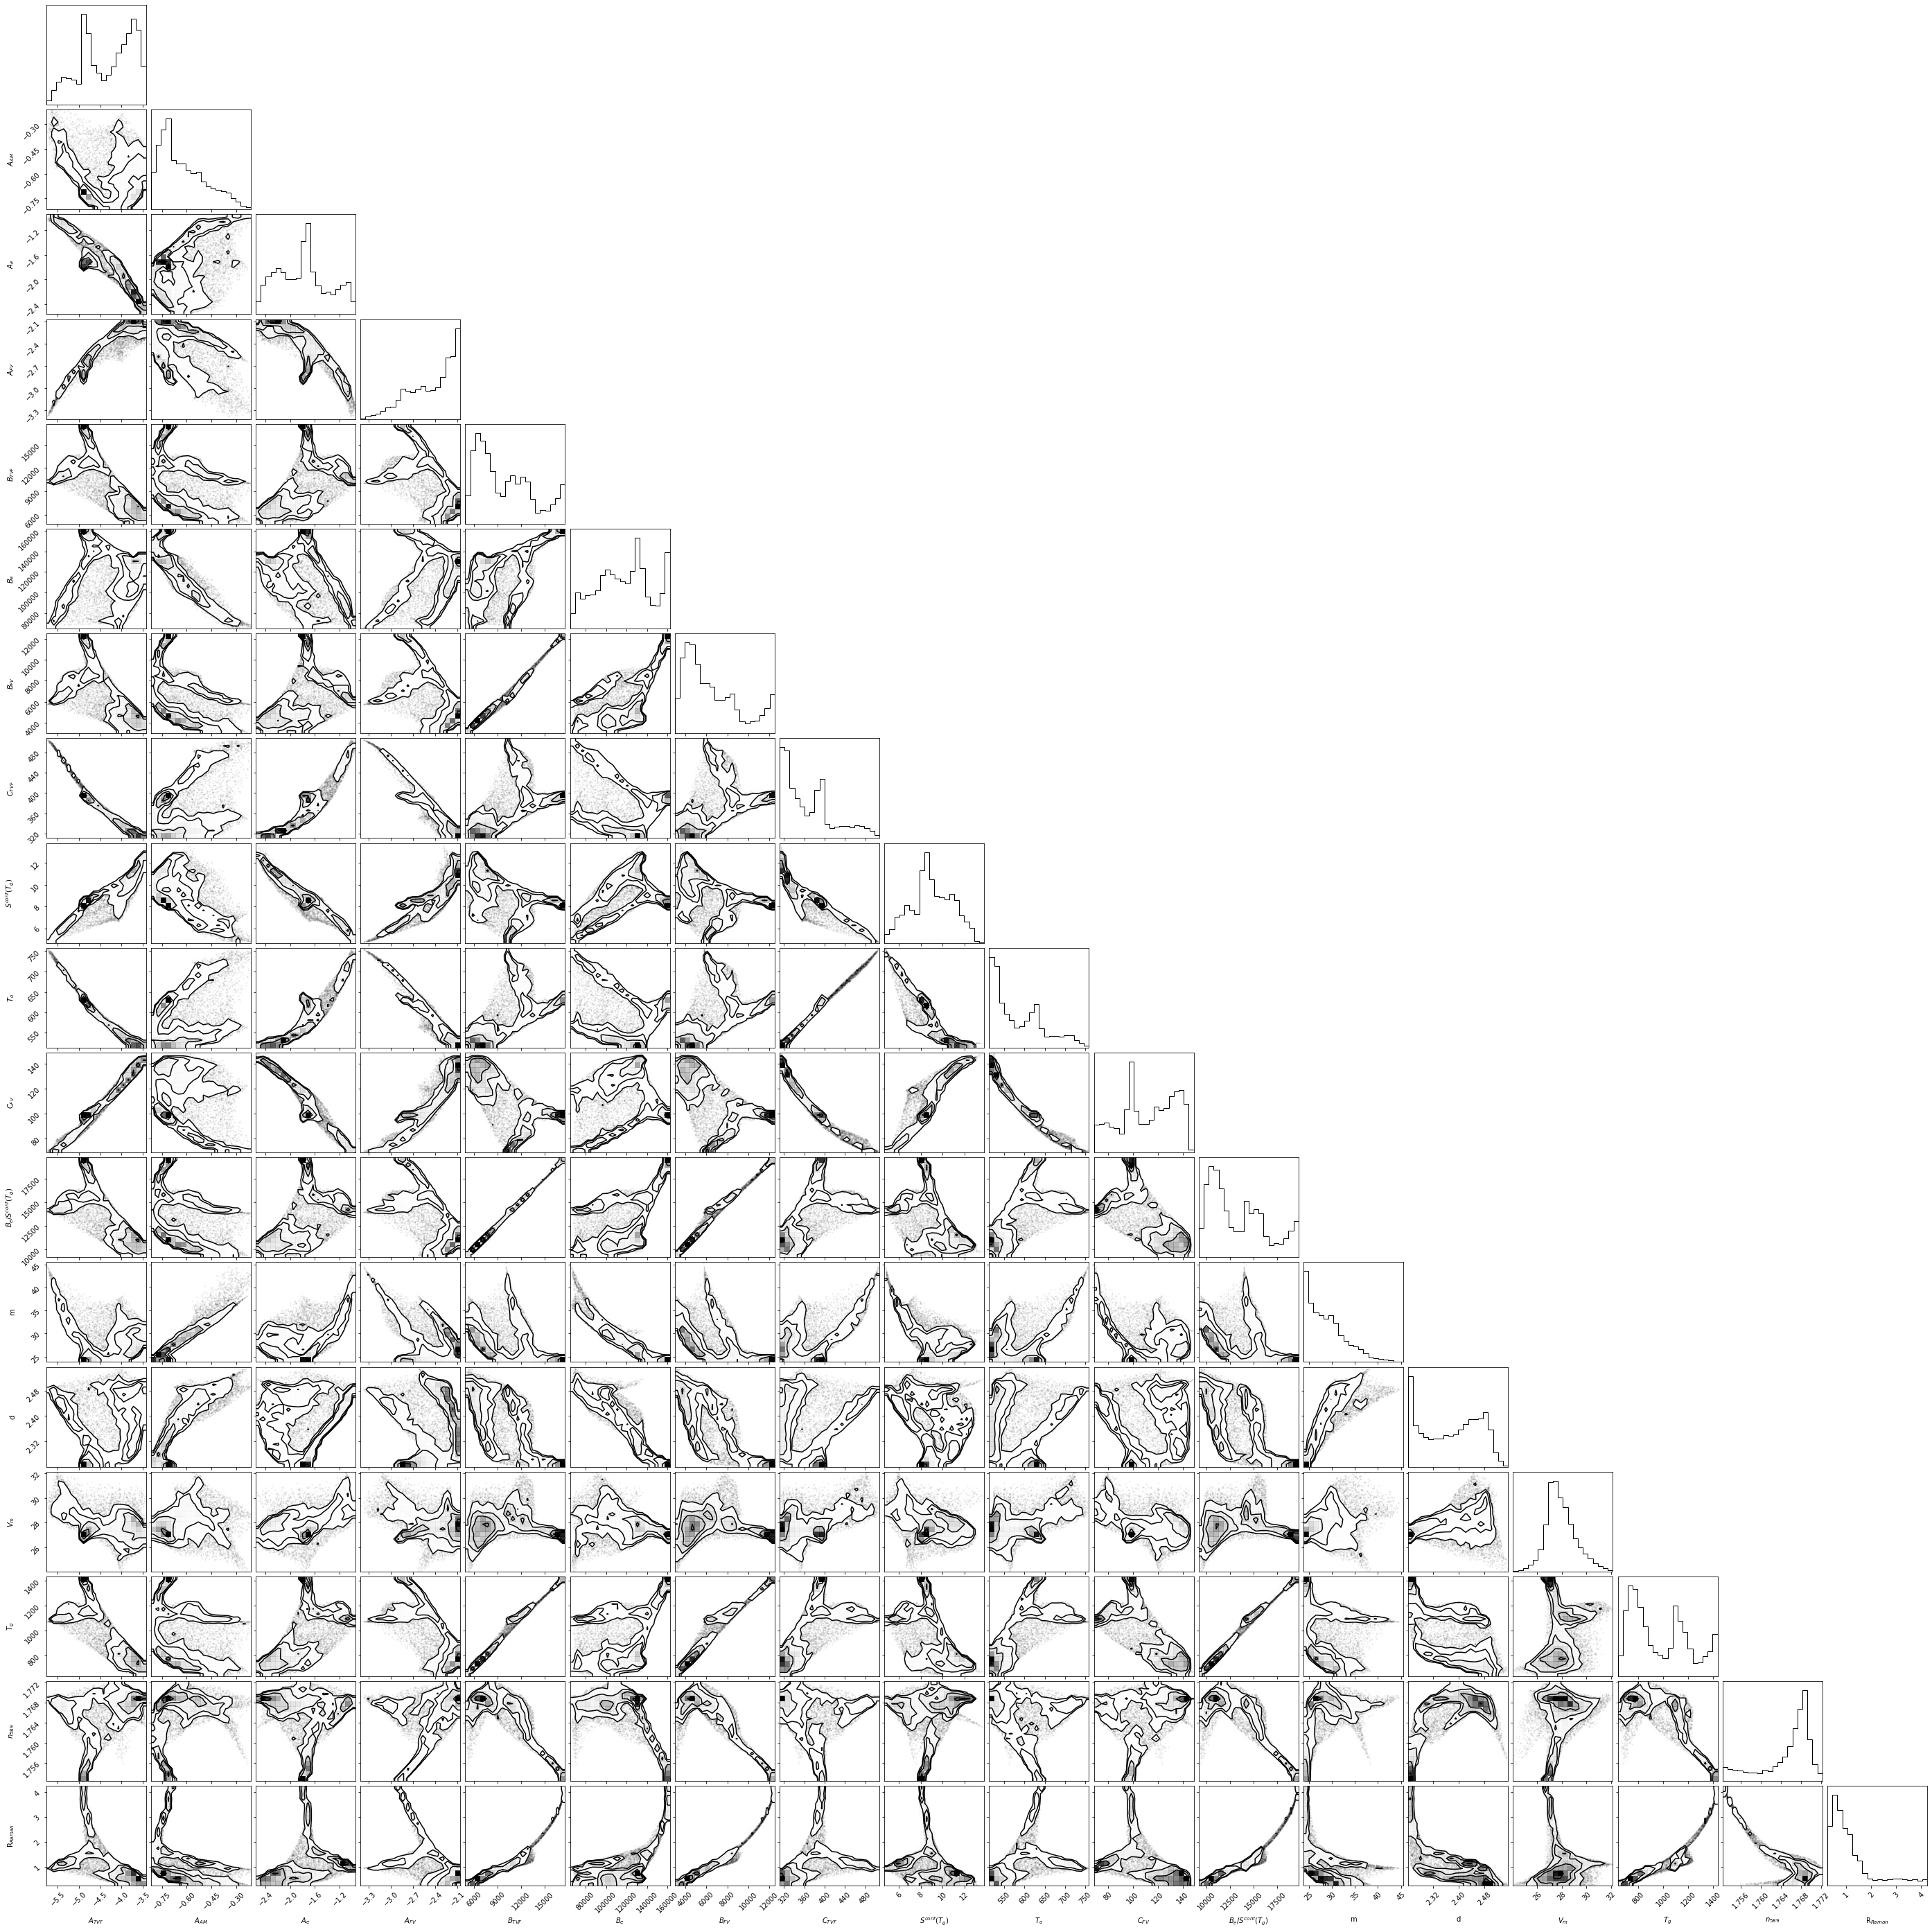

In [12]:
plt.figure(figsize=(15,15))
corner.corner(samples, labels=labels);

# Figure 9: correlation matrice

Below we test Spearman correlations between variables, allows to see unlinear correlated features.

/home/charles/anaconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


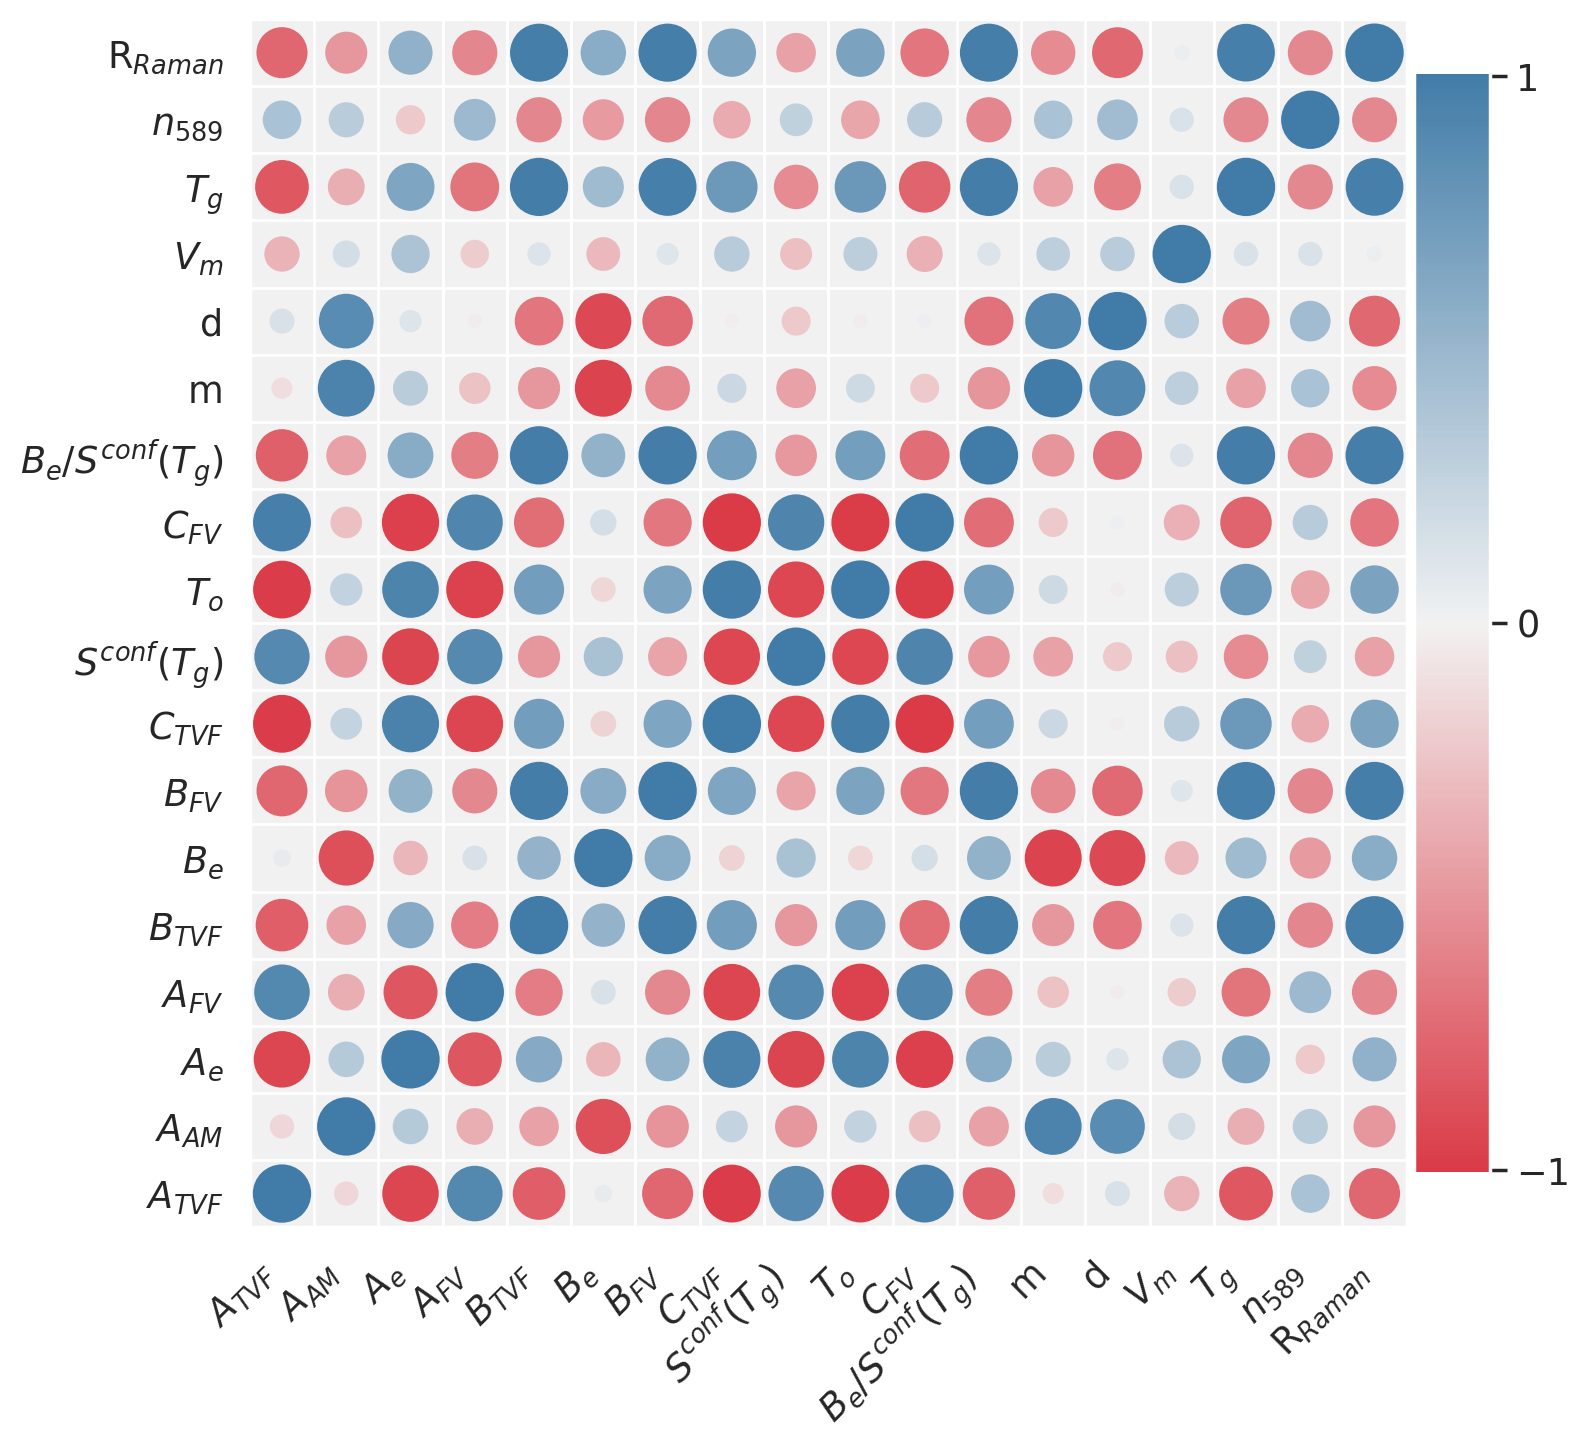

In [13]:
df_samples = pd.DataFrame(data= samples, columns=labels)

sp_corr = df_samples.corr(method="spearman")

# old figure code
#figc = plt.figure(figsize=(8,8))
#ax = plt.subplot()
#sns.heatmap(sp_corr, annot=False, fmt='.2f', center=False,
#            cmap=plt.get_cmap('coolwarm'), cbar=True, cbar_kws = {"label":"Spearman correlation coefficient"},ax=ax, vmin=-1, vmax=1)
#ax.set_yticklabels(ax.get_yticklabels(), rotation="horizontal")
#plt.tight_layout()

# new figure generated using heatmapz, see https://github.com/dylan-profiler/heatmaps
from heatmap import heatmap, corrplot
sns.set(color_codes=True, font_scale=1.2)
figc = plt.figure(figsize=(8,8), dpi=200)
corr = pd.melt(sp_corr.reset_index(), id_vars='index').replace(np.nan, 0)
corr.columns = ['x', 'y', 'value']
heatmap(
    corr['x'], corr['y'],
    color=corr['value'], color_range=[-1, 1],
    palette=sns.diverging_palette(10, 240, n=256),
    size=corr['value'].abs(), size_range=[0,1],
    marker='o',
    x_order=sp_corr.columns,
    y_order=sp_corr.columns[:],
    size_scale=400
)
plt.tight_layout()
plt.savefig('./figures/Figure9_correlations.pdf', bbox_inches='tight', pad_inches=0.0)

matplotlib.rc_file_defaults() # to erase sns modifications to matplotlib default

# Figure 6: Comparison between known values and predictions for other parameters (Tg, entropy...)

Tg test RMSE: 16.0
ScTg test RMSE: 0.8
density test RMSE: 0.050
Refractive index test RMSE: 0.0047
Raman test RMSE: 16.0


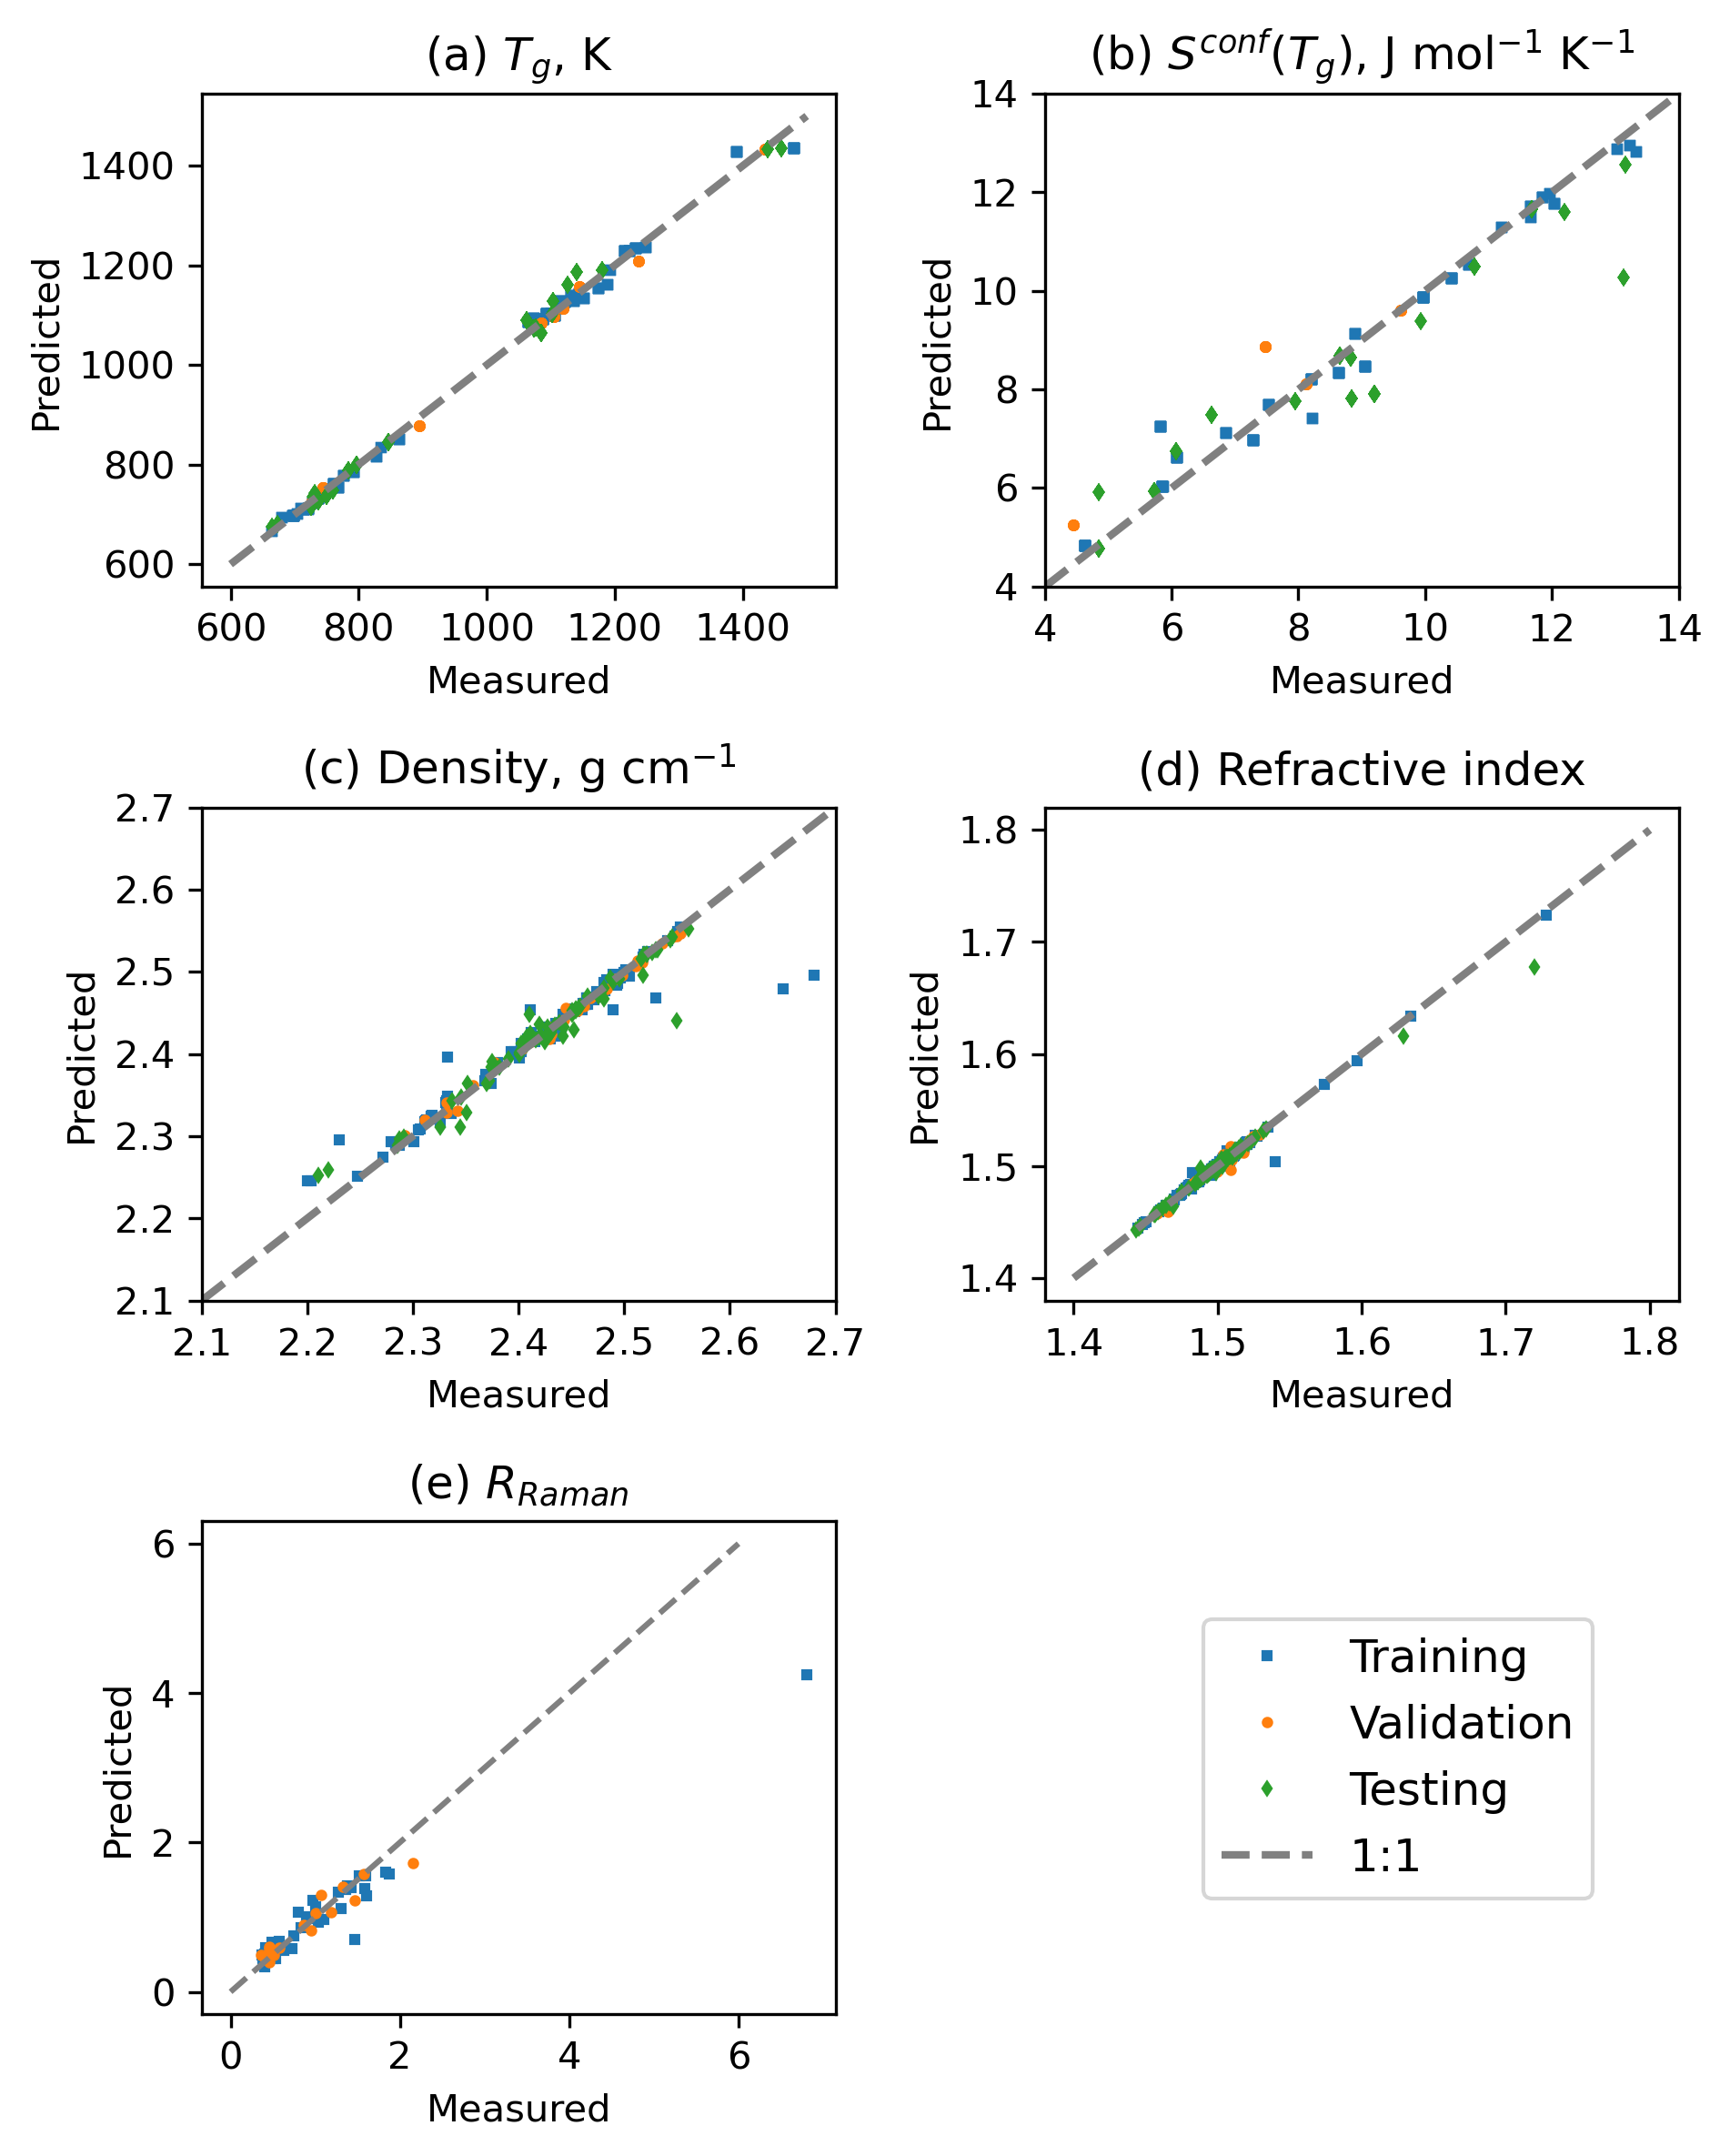

In [14]:
plt.figure(figsize=(6.44,8),dpi=300)

#
# Glass transition temperature
#
tx1 = plt.subplot(3,2,1)
tx1.plot(ds.y_tg_train.cpu().detach().numpy(),neuralmodel.predict("tg",ds.x_tg_train).mean(axis=1),
         "s",linestyle="none",color="C0",markersize=2,label="Train",alpha=1)
tx1.plot(ds.y_tg_valid.cpu().detach().numpy(),neuralmodel.predict("tg",ds.x_tg_valid).mean(axis=1),
         "o",color="C1",markersize=2,label="Valid",alpha=1)
tx1.plot(ds.y_tg_test.cpu().detach().numpy(),neuralmodel.predict("tg",ds.x_tg_test).mean(axis=1),
         "d",color="C2",markersize=2,label="Test",alpha=1)
RMSE_test_Tg = np.sqrt(mean_squared_error(ds.y_tg_test.cpu().detach().numpy(),neuralmodel.predict("tg",ds.x_tg_test).mean(axis=1))) 
print("Tg test RMSE: {0:.1f}".format(RMSE_test_Tg))

plt.xlabel("Measured")
plt.ylabel("Predicted")
plt.title(r"(a) $T_g$, K")

plt.plot([600,1500],[600,1500],"--",color="grey",linewidth=2,label="1:1")

#
# Configurational entropy
#

tx2 = plt.subplot(3,2,2)
tx2.plot(ds.y_entro_train.cpu().detach().numpy(),neuralmodel.predict("sctg",ds.x_entro_train).mean(axis=1),
         "s",color="C0",markersize=2,label="Train",alpha=1)
tx2.plot(ds.y_entro_valid.cpu().detach().numpy(),neuralmodel.predict("sctg",ds.x_entro_valid).mean(axis=1),
         "o",color="C1",markersize=2,label="Valid",alpha=1)
tx2.plot(ds.y_entro_test.cpu().detach().numpy(),neuralmodel.predict("sctg",ds.x_entro_test).mean(axis=1),
         "d",color="C2",markersize=2,label="Test",alpha=1)
RMSE_test_ScTg = np.sqrt(mean_squared_error(ds.y_entro_test.cpu().detach().numpy(),neuralmodel.predict("sctg",ds.x_entro_test).mean(axis=1))) 
print("ScTg test RMSE: {0:.1f}".format(RMSE_test_ScTg))

plt.xlabel("Measured")
plt.ylabel("Predicted")
plt.title(r"(b) $S^{conf}(T_g)$, J mol$^{-1}$ K$^{-1}$")
plt.xlim(4,14)
plt.ylim(4,14)
plt.plot([4,14],[4,14],"--",color="grey",linewidth=2,label="1:1")

#
# Density
#

tx3=plt.subplot(3,2,3)
tx3.plot(ds.y_density_train.cpu().detach().numpy(),neuralmodel.predict("density",ds.x_density_train).mean(axis=1),
         "s",color="C0",markersize=2,label="Train",alpha=1)
tx3.plot(ds.y_density_valid.cpu().detach().numpy(),neuralmodel.predict("density",ds.x_density_valid).mean(axis=1),
         "o",color="C1",markersize=2,label="Valid",alpha=1)
tx3.plot(ds.y_density_test.cpu().detach().numpy(),neuralmodel.predict("density",ds.x_density_test).mean(axis=1),
         "d",color="C2",markersize=2,label="Test",alpha=1)
RMSE_test_d = np.sqrt(mean_squared_error(ds.y_density_test.cpu().detach().numpy(),neuralmodel.predict("density",ds.x_density_test).mean(axis=1))) 
print("density test RMSE: {0:.3f}".format(RMSE_test_d))


plt.xlabel("Measured")
plt.ylabel("Predicted")
plt.title(r"(c) Density, g cm$^{-1}$")

plt.plot([2.1,2.7],[2.1,2.7],"--",color="grey",linewidth=2,label="1:1")

plt.xlim(2.1,2.7)
plt.ylim(2.1,2.7)
plt.xticks([2.1,2.2,2.3,2.4,2.5,2.6,2.7])
plt.yticks([2.1,2.2,2.3,2.4,2.5,2.6,2.7])

#
# Refractive index
#

tx4 = plt.subplot(3,2,4)

tx4.plot(ds.y_ri_train.cpu().detach().numpy(),neuralmodel.predict("sellmeier",ds.x_ri_train, lbd=ds.lbd_ri_train).mean(axis=1),
         "s",color="C0",markersize=2,label="Training",alpha=1.)
tx4.plot(ds.y_ri_valid.cpu().detach().numpy(),neuralmodel.predict("sellmeier",ds.x_ri_valid, lbd=ds.lbd_ri_valid).mean(axis=1),
         "o",color="C1",markersize=2,label="Validation",alpha=1.)
tx4.plot(ds.y_ri_test.cpu().detach().numpy(),neuralmodel.predict("sellmeier",ds.x_ri_test, lbd=ds.lbd_ri_test).mean(axis=1),
         "d",color="C2",markersize=2,label="Testing",alpha=1.)
RMSE_test_ri = np.sqrt(mean_squared_error(ds.y_ri_test.cpu().detach().numpy(),neuralmodel.predict("sellmeier",ds.x_ri_test, lbd=ds.lbd_ri_test).mean(axis=1))) 
print("Refractive index test RMSE: {0:.4f}".format(RMSE_test_ri))

plt.xlabel("Measured")
plt.ylabel("Predicted")
plt.title(r"(d) Refractive index")

plt.plot([1.4,1.8],[1.4,1.8],"--",color="grey",linewidth=2,label="1:1")
plt.xticks(np.arange(1.4,1.8,0.1))
plt.yticks(np.arange(1.4,1.8,0.1))

#
# Raman predictions : ratio of low to high frequency peaks
#

tx5 = plt.subplot(3,2,5)

plt.plot(Rr_train,Rr_train_pred,"s",color="C0",alpha=1.,markersize=2,label="Training")
plt.plot(Rr_valid,Rr_valid_pred,"o",color="C1",alpha=1.,markersize=2,label="Validation")
plt.plot([0,6],[0,6],"--",color="grey")
RMSE_test_ri = np.sqrt(mean_squared_error(Rr_valid_pred,Rr_valid)) 
print("Raman test RMSE: {0:.1f}".format(RMSE_test_Tg))

plt.xlabel("Measured")
plt.ylabel("Predicted")
plt.title(r"(e) $R_{Raman}$")

plt.tight_layout()

tx4.legend(fontsize=12, bbox_to_anchor=(0.9,-0.6))

plt.savefig("./figures/Figure6_compproperties.pdf")

# Figure 7: Fragility versus $C_p^{conf}/S^{conf}(T_g)$

A linear relationship should be visible according to the works of Webb (2008) or Russell and Giordano (2017)

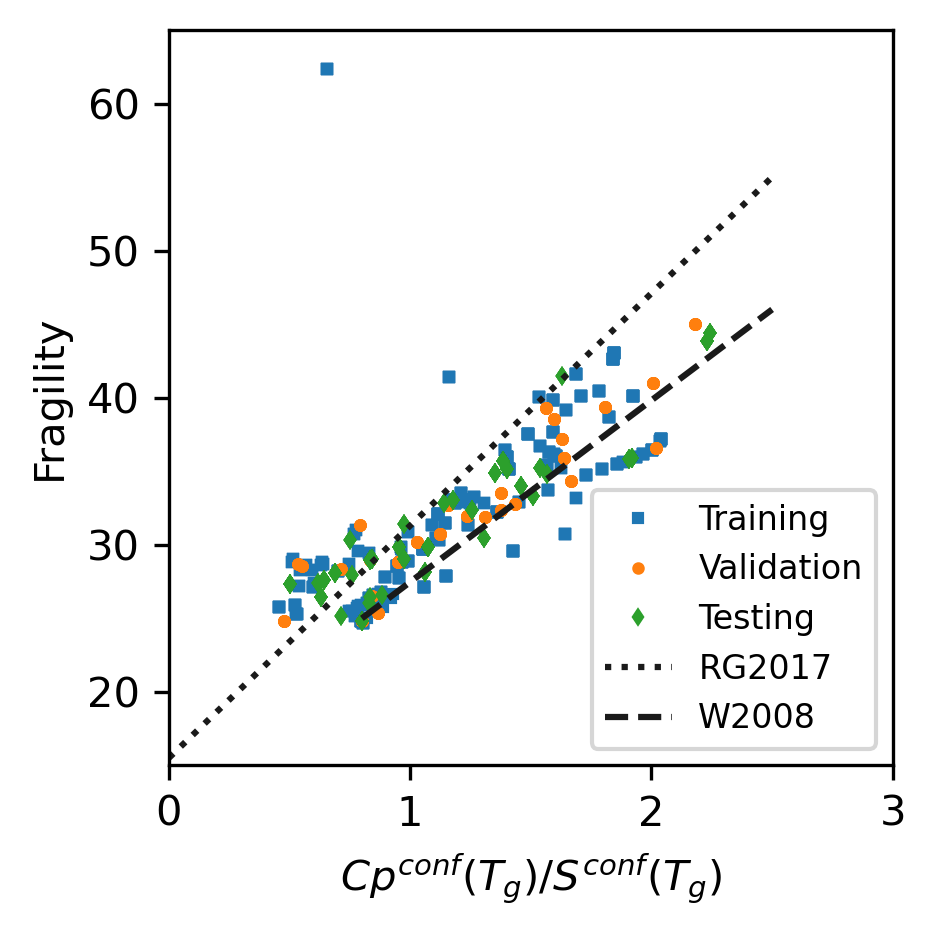

In [15]:
plt.figure(figsize=(3.22,3.22),dpi=300)
# Train

Cpconf = neuralmodel.predict("ap_calc",ds.x_visco_train).mean(axis=1) + neuralmodel.predict("b_calc",ds.x_visco_train).mean(axis=1)* neuralmodel.predict("tg",ds.x_visco_train).mean(axis=1)
Cp_S = Cpconf/neuralmodel.predict("sctg",ds.x_visco_train).mean(axis=1)

plt.plot(Cp_S,neuralmodel.predict("fragility",ds.x_visco_train).mean(axis=1),
         "s",color="C0",markersize=2,label="Training")

# Valid
Cpconf = neuralmodel.predict("ap_calc",ds.x_visco_valid).mean(axis=1) + neuralmodel.predict("b_calc",ds.x_visco_valid).mean(axis=1)* neuralmodel.predict("tg",ds.x_visco_valid).mean(axis=1)
Cp_S = Cpconf/neuralmodel.predict("sctg",ds.x_visco_valid).mean(axis=1)

plt.plot(Cp_S,neuralmodel.predict("fragility",ds.x_visco_valid).mean(axis=1),
         "o",color="C1",markersize=2,label="Validation")

# Test
Cpconf = neuralmodel.predict("ap_calc",ds.x_visco_test).mean(axis=1) + neuralmodel.predict("b_calc",ds.x_visco_test).mean(axis=1)* neuralmodel.predict("tg",ds.x_visco_test).mean(axis=1)
Cp_S = Cpconf/neuralmodel.predict("sctg",ds.x_visco_test).mean(axis=1)

plt.plot(Cp_S,neuralmodel.predict("fragility",ds.x_visco_test).mean(axis=1),
         "d",color="C2",markersize=2,label="Testing")

plt.plot([0., 2.5],[15.51, 55],"k:",label="RG2017")
plt.plot([0.8, 2.5],[25., 46],"k--",label="W2008")

plt.xlabel(r"$Cp^{conf}(T_g)/S^{conf}(T_g)$")
plt.ylabel("Fragility")

plt.xlim(0,3)
plt.ylim(15,65)

plt.legend(fontsize = 8, loc=4)
plt.tight_layout()
plt.savefig("./figures/Figure7_mVSCpS.pdf")

# Figure 8: structure and property links

['$n_{589}$', '$B_e/S^{conf}(T_g)$', '$B_{CG}$', '$T_g$', 'R$_{Raman}$']


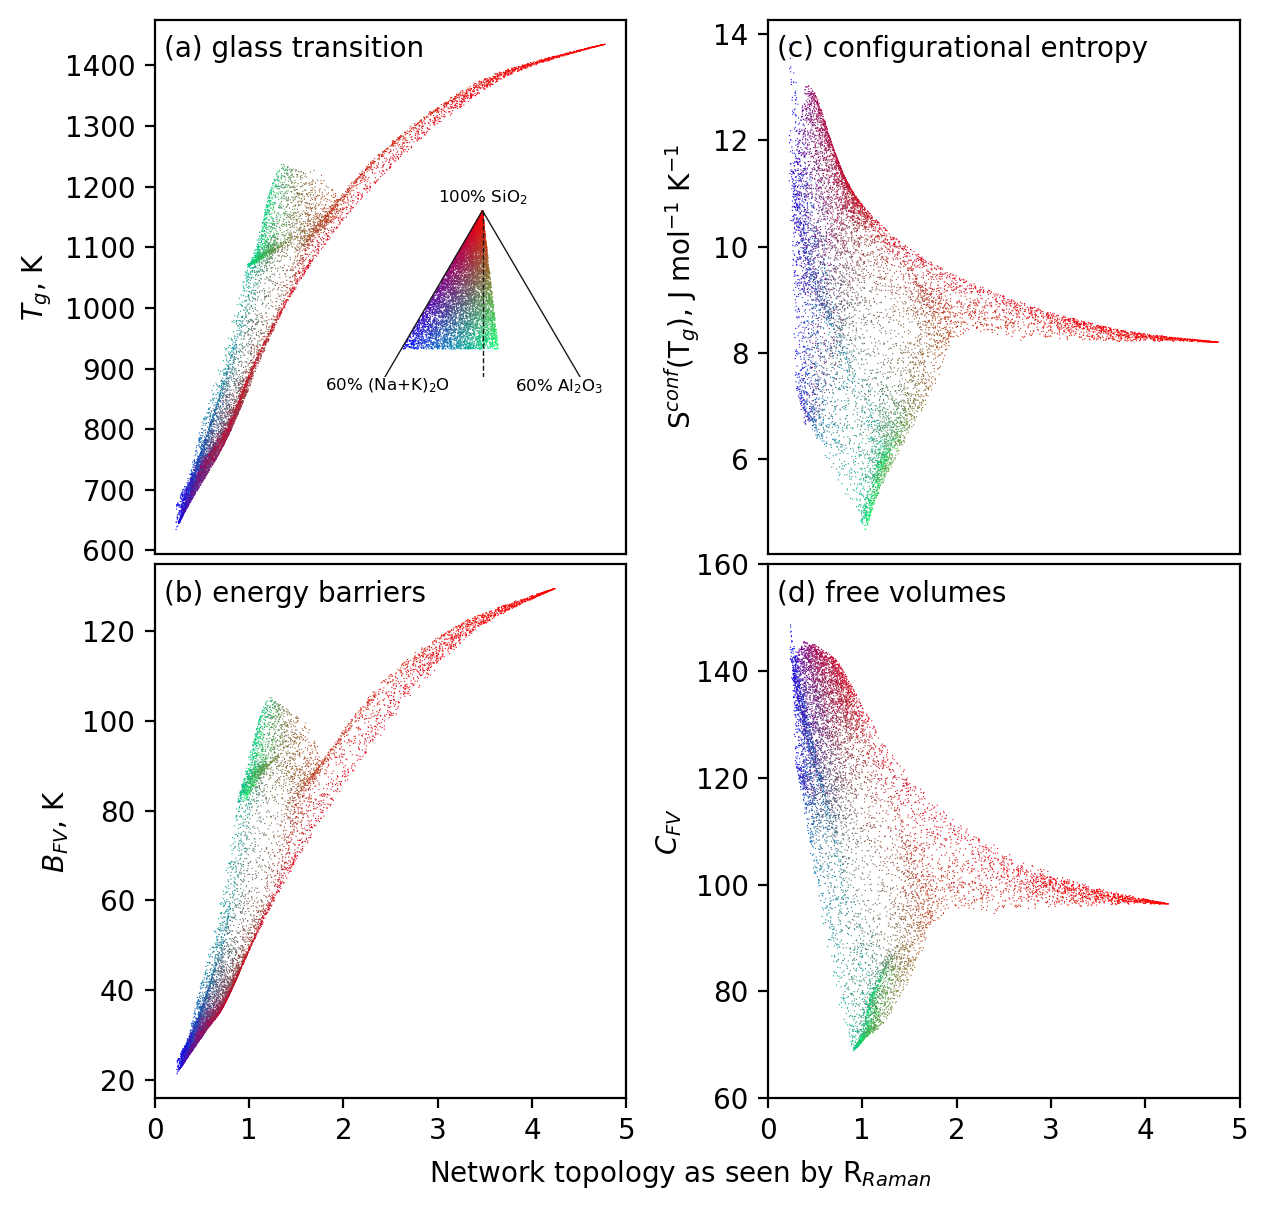

In [16]:
def CLR(input_array):
    """Transform chemical composition in colors
    
    Inputs
    ------
    input_array: n*4 array
        4 chemical inputs with sio2, al2o3, k2o and na2o in 4 columns, n samples in rows
        
    Returns
    -------
    out: n*3 array
        RGB colors
    """
    XXX = input_array.copy()
    XXX[:,2] = XXX[:,2]+XXX[:,3] # adding alkalis
    out = np.delete(XXX,3,1) # remove 4th row
    # min max scaling to have colors in the full RGB scale
    out[:,0] = (out[:,0]-out[:,0].min())/(out[:,0].max()-out[:,0].min())
    out[:,1] = (out[:,1]-out[:,1].min())/(out[:,1].max()-out[:,1].min())
    out[:,2] = (out[:,2]-out[:,2].min())/(out[:,2].max()-out[:,2].min())
    return out

X_rec_forcart = X_rec
X_rec_forcart["alkalis"] = X_rec.na2o+X_rec.k2o
cart_rec = neuravi.bary2cart(X_rec_forcart.loc[:,["alkalis","sio2","al2o3"]].values, corners=np.array([[0,0],[1,1],[2,0]]))

fig2n = plt.figure(figsize=(7,7),dpi=200)

gs = GridSpec(2, 2, figure=fig2n, hspace=0.02, wspace=0.30)

fig2n_a = fig2n.add_subplot(gs[0, 0])
fig2n_b = fig2n.add_subplot(gs[1, 0])
fig2n_d = fig2n.add_subplot(gs[0, 1])
fig2n_e = fig2n.add_subplot(gs[1, 1])

####
#### TERNARY PLOT
####

# Create inset of width 1.3 inches and height 0.9 inches
# at the default upper right location
axins = inset_axes(fig2n_a, width=1.3, height=0.9,loc='right')

axins.scatter(cart_rec[:,0],cart_rec[:,1],s=0.2,linewidth=0.5,edgecolor='none',c=CLR(X_gen.detach().numpy()))
axins.plot([1,1],[0,1],"k--",linewidth=0.5)
axins.plot([0,1,2,0],[0,1,0,0],"k-",linewidth=0.5)

axins.set_xlim(0.2,1.8)
axins.set_ylim(0.4,1.05)

axins.annotate(r"100% SiO$_2$", xy = (1,1.03),xycoords="data",ha="center",fontsize=6)
axins.annotate(r"60% Al$_2$O$_3$", xy = (1.2,0.4),xycoords="data",ha="left",va="top",fontsize=6)
axins.annotate(r"60% (Na+K)$_2$O", xy = (0.8,0.4),xycoords="data",ha="right",va="top",fontsize=6)

axins.axis("off")

####
#### DATA PLOT
####

fig2n_a.scatter(samples_2[:,4],samples_2[:,3],s=.2,edgecolor='none',c=CLR(X_gen.detach().numpy()))
fig2n_b.scatter(samples_2[:,4],samples_2[:,2],s=.2,edgecolor='none',c=CLR(X_gen.detach().numpy()))
fig2n_d.scatter(Rr_gen.reshape(-1,1), neuralmodel.predict("sctg",X_gen).mean(axis=1), s=.2,edgecolor='none',c=CLR(X_gen.detach().numpy()))
fig2n_e.scatter(Rr_gen.reshape(-1,1), neuralmodel.predict("c_cg",X_gen).mean(axis=1), s=.2,edgecolor='none',c=CLR(X_gen.detach().numpy()))
#fig2n_d.set_ylim(4,14)
fig2n_e.set_ylim(60,160)


fig2n_a.set_ylabel("$T_{g}$, K")
fig2n_b.set_ylabel("$B_{FV}$, K")
fig2n_d.set_ylabel(r"S$^{conf}$(T$_{g}$), J mol$^{-1}$ K$^{-1}$")
fig2n_e.set_ylabel(r"$C_{FV}$")
fig2n.text(0.5,0.05,'Network topology as seen by R$_{Raman}$',ha="center")

fig2n_a.set_xticks([])
fig2n_d.set_xticks([])
fig2n_b.set_xticks([0,1,2,3,4,5])
fig2n_e.set_xticks([0,1,2,3,4,5])

#
# Annotations
#
fig2n_a.annotate("(a) glass transition", xy=(0.02,0.93),xycoords="axes fraction")
fig2n_b.annotate("(b) energy barriers", xy=(0.02,0.93),xycoords="axes fraction")
fig2n_d.annotate("(c) configurational entropy", xy=(0.02,0.93),xycoords="axes fraction")
fig2n_e.annotate("(d) free volumes", xy=(0.02,0.93),xycoords="axes fraction")

print(labels_2)

#plt.tight_layout()

plt.savefig("./figures/Figure8_Rraman_properties.pdf",bbox_inches="tight")

# Figure 10 : High temperature limit

/home/charles/anaconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:55: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


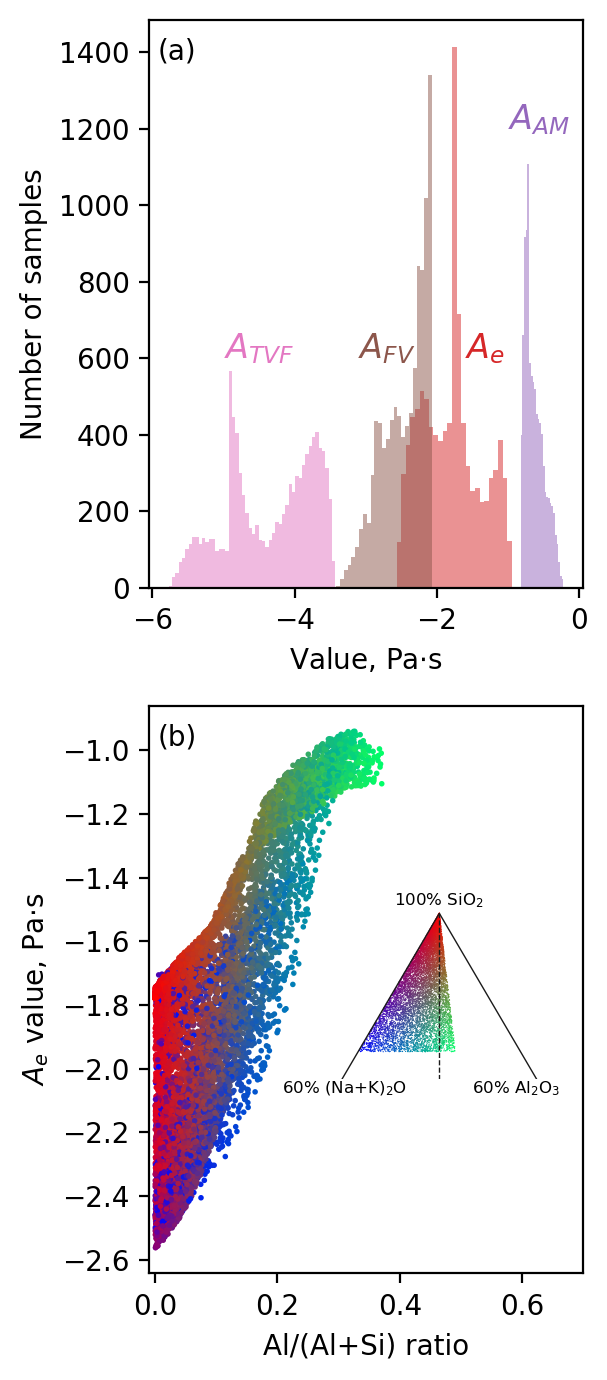

In [17]:
###
### FIRST SUBPLOT
###

plt.figure(figsize=(3.22,7), dpi=200)

ax0 = plt.subplot(2,1,1)
ax0.hist(samples[:,2],bins=25, alpha = 0.5, color="C3", density=False, label='$A_e$')
ax0.hist(samples[:,1],bins=25, alpha = 0.5, color="C4", density=False,label='$A_{AM}$')
ax0.hist(samples[:,3],bins=25, alpha = 0.5, color="C5", density=False,label='$A_{FV}$')
ax0.hist(samples[:,0],bins=50,alpha=0.5, color="C6", density=False,label='$A_{TVF}$')

ax0.annotate('$A_e$', xy=(-1.6,600),color='C3',fontsize=12)
ax0.annotate('$A_{AM}$', xy=(-1.0,1200),color='C4',fontsize=12)
ax0.annotate('$A_{FV}$', xy=(-3.1,600),color='C5',fontsize=12)
ax0.annotate('$A_{TVF}$', xy=(-5.,600),color='C6',fontsize=12)

plt.xlabel("Value, Pa$\cdot$s")
plt.ylabel("Number of samples")
plt.annotate("(a)", xy=(0.02,0.93),xycoords="axes fraction")

###
### SECOND SUBPLOT
###

ax = plt.subplot(2,1,2)
#### TERNARY INSERT PLOT

# Create inset of width 1.3 inches and height 0.9 inches
# at the default upper right location
axins = inset_axes(ax, width=1.3, height=0.9,loc="right")

axins.scatter(cart_rec[:,0],cart_rec[:,1],s=0.2,linewidth=0.5,edgecolor='none',c=CLR(X_gen.detach().numpy()))
axins.plot([1,1],[0,1],"k--",linewidth=0.5)
axins.plot([0,1,2,0],[0,1,0,0],"k-",linewidth=0.5)

axins.set_xlim(0.2,1.8)
axins.set_ylim(0.4,1.05)

axins.annotate(r"100% SiO$_2$", xy = (1,1.03),xycoords="data",ha="center",fontsize=6)
axins.annotate(r"60% Al$_2$O$_3$", xy = (1.2,0.4),xycoords="data",ha="left",va="top",fontsize=6)
axins.annotate(r"60% (Na+K)$_2$O", xy = (0.8,0.4),xycoords="data",ha="right",va="top",fontsize=6)

axins.axis("off")

# MAIN PLOT

ax.scatter(X_gen[:,1]/(X_gen[:,0]+X_gen[:,1]),samples[:,2],s=1,c=CLR(X_gen.detach().numpy()))
ax.set_xlabel("Al/(Al+Si) ratio")
ax.set_xlim(-0.01,0.7)
ax.set_ylabel("$A_e$ value, Pa$\cdot$s")

ax.annotate("(b)", xy=(0.02,0.93),xycoords="axes fraction")

plt.tight_layout()

plt.savefig("./figures/Figure10_infinitevisco.pdf")

# Figure 11 : configurational entropy

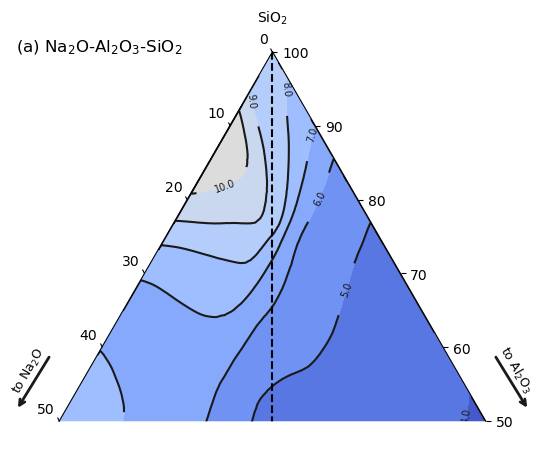

In [22]:
sctg_NAS = neuralmodel.predict("sctg",X_gen_NAS).mean(axis=1)
   
def make_ternary(ax,t,l,r, z, 
                 labelt,labell,labelr, 
                 levels, levels_l, c_m, norm, 
                 boundaries_SiO2,
                annotation = "(a)"):

    ax.plot([1.0,0.5],[0.,0.5],[0.,0.5],"--",color="black")
    
    ax.tricontourf(t,l,r,z,
                levels=levels, cmap=c_m, norm=norm)

    tc = ax.tricontour(t,l,r,z,
                    levels=levels_l,colors='k', norm=norm)
    
    ax.clabel(tc, inline=1, fontsize=7, fmt="%1.1f")

    ax.set_tlabel(labelt)
    #ax.set_llabel(labell)
    #ax.set_rlabel(labelr)

    ax.taxis.set_label_rotation_mode('horizontal')
    #ax.laxis.set_tick_rotation_mode('horizontal')
    #ax.raxis.set_label_rotation_mode('horizontal')
    
    make_arrow(ax, "to Na$_2$O", "to Al$_2$O$_3$")

    ax.raxis.set_ticks([])
    
    # Using ``ternary_lim``, you can limit the range of ternary axes.
    # Be sure about the consistency; the limit values must satisfy:
    # tmax + lmin + rmin = tmin + lmax + rmin = tmin + lmin + rmax = ternary_scale
    ax.set_ternary_lim(
        boundaries_SiO2[0], boundaries_SiO2[1],  # tmin, tmax
        0.0, boundaries_SiO2[0],  # lmin, lmax
        0.0, boundaries_SiO2[0],  # rmin, rmax
    )

    ax.annotate(annotation, xy=(-0.1,1.0), xycoords="axes fraction", fontsize=12)
    
    ax.spines['tside'].set_visible(False)

    #ax.annotate(labell, xy=(-0.1,-0.07), xycoords="axes fraction", ha="center")
    #ax.annotate(labelr, xy=(1.1,-0.07), xycoords="axes fraction", ha="center")
    
    ax.tick_params(labelrotation='horizontal')

def make_arrow(ax, labell, labelr, sx1 = -0.1, sx2 = 1.02, fontsize = 9, linewidth = 2):
    ax.annotate('', xy=(sx1, 0.03), xycoords='axes fraction', xytext=(sx1+0.08, 0.18), 
            arrowprops=dict(arrowstyle="->", color='k',linewidth=linewidth))

    ax.annotate(labell, xy=(sx1+0.03
                                  ,0.08), xycoords="axes fraction", 
                ha="center",rotation=60,fontsize = fontsize)
    
    ax.annotate('', xy=(sx2, 0.18), xycoords='axes fraction', xytext=(sx2+0.08, 0.03), 
                arrowprops=dict(arrowstyle="<-", color='k',linewidth=linewidth))
    
    ax.annotate(labelr, xy=(sx2+0.05,0.08), xycoords="axes fraction", 
                ha="center",rotation=-60, fontsize = fontsize)

    
ax = plt.subplot(projection='ternary', ternary_scale=100)

levels = np.arange(3,18,1)
levels_l = np.arange(3,18,1)
c_m = matplotlib.cm.coolwarm # choose a colormap
norm = matplotlib.colors.Normalize(
    vmin=3.0,
    vmax=18.0) # Manual setup

make_ternary(ax, 
             X_gen_NAS_rec.sio2, X_gen_NAS_rec.na2o, X_gen_NAS_rec.al2o3,sctg_NAS,
             'SiO$_2$', 'To K$_2$O', 'To Al$_2$O$_3$',
            levels, levels_l, c_m, norm,
             [50,100],
            annotation = "(a) Na$_2$O-Al$_2$O$_3$-SiO$_2$")


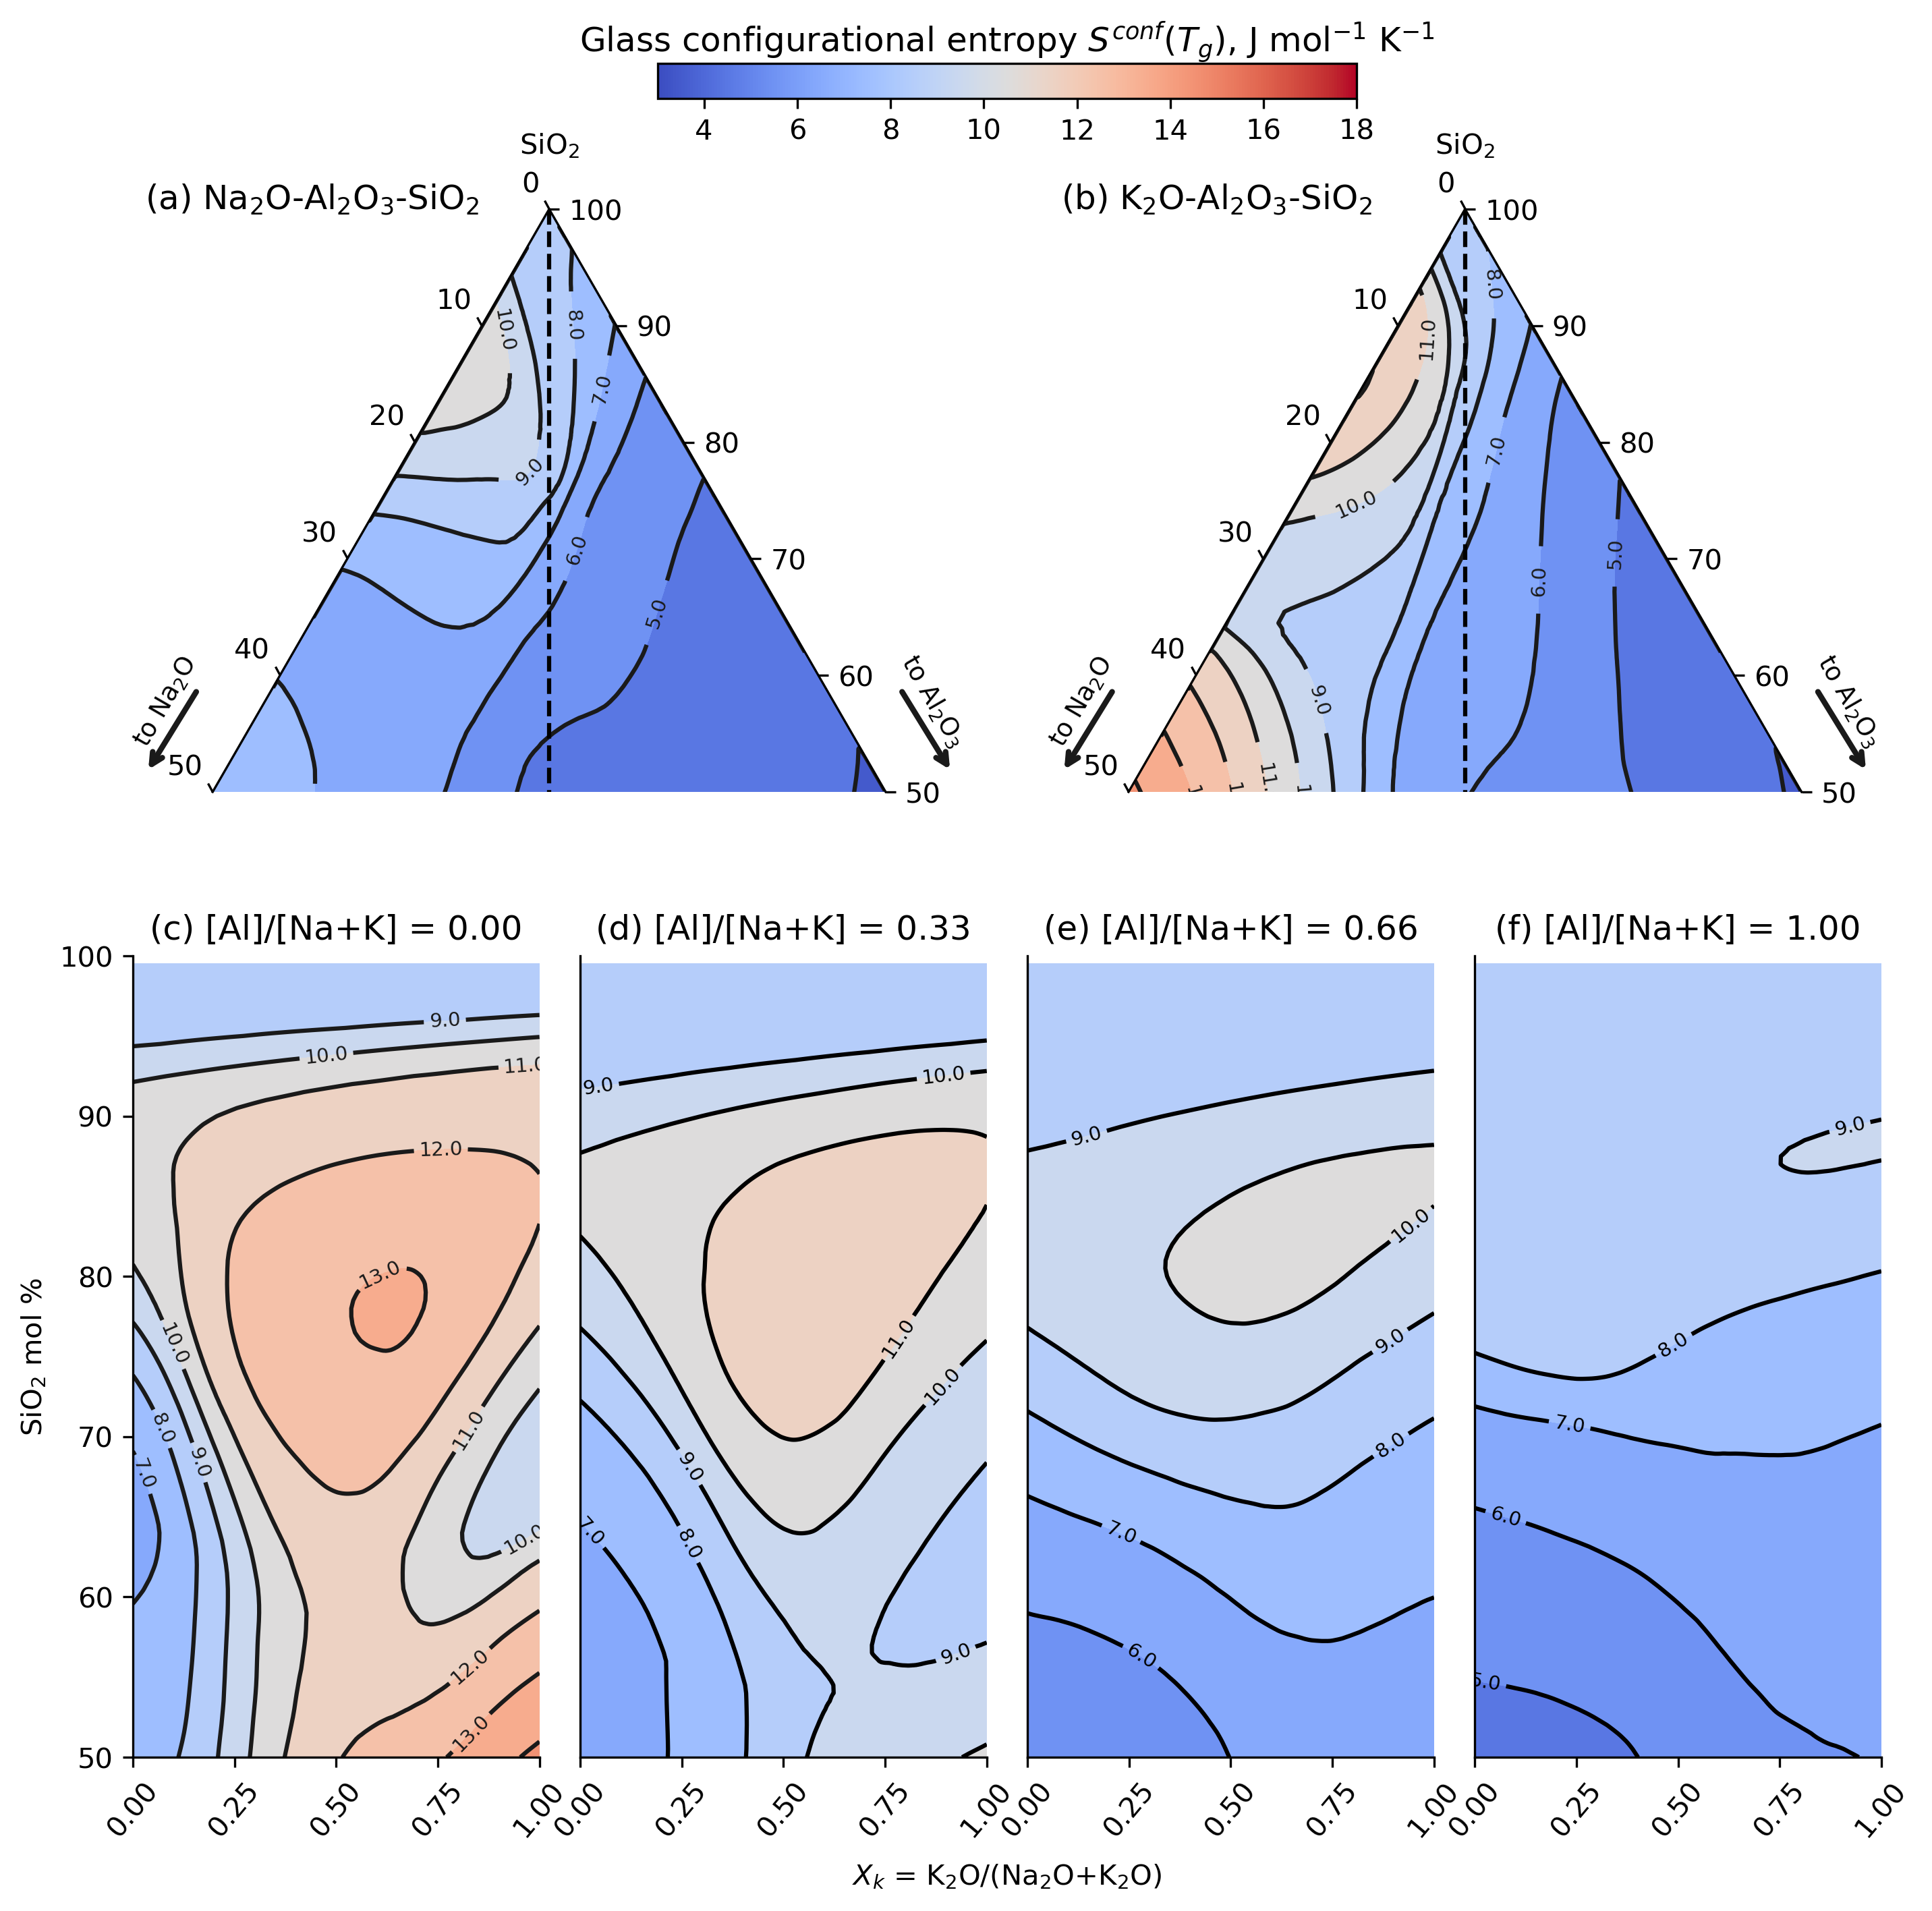

In [23]:
#APV: Added lines to contour plots for clarity
#     Increased levels for smoothness
#     Minor tweaks to layout
#     Wonder if colourbar limits should be changed to be integers for better labeling?

####
#### GENERATING ENTROPY
####

# grabing the entropies along NS/KS
sctg_NAS = neuralmodel.predict("sctg",X_gen_NAS).mean(axis=1)
sctg_KAS = neuralmodel.predict("sctg",X_gen_KAS).mean(axis=1)
sctg_all = neuralmodel.predict("sctg",X_gen_all).mean(axis=1)

# grabing the entropies for the mixtures
sctg_RS_Xk = neuralmodel.predict("sctg",X_gen_RS_Xk_rec.loc[:,["sio2","al2o3","na2o","k2o"]].values).mean(axis=1)
sctg_R3_Xk = neuralmodel.predict("sctg",X_gen_R3_Xk_rec.loc[:,["sio2","al2o3","na2o","k2o"]].values).mean(axis=1)
sctg_R2_Xk = neuralmodel.predict("sctg",X_gen_R2_Xk_rec.loc[:,["sio2","al2o3","na2o","k2o"]].values).mean(axis=1)
sctg_R1_Xk = neuralmodel.predict("sctg",X_gen_R1_Xk_rec.loc[:,["sio2","al2o3","na2o","k2o"]].values).mean(axis=1)

####
#### COLOR CALCULATIONS
####

trig_color_plot = sctg_all # for the colors > same scale 

# norm is a class which, when called, can normalize data into the
# [0.0, 1.0] interval.
norm = matplotlib.colors.Normalize(
    vmin=3.0,
    vmax=18.0) # Manual setup

c_m = matplotlib.cm.coolwarm # choose a colormap
s_m = matplotlib.cm.ScalarMappable(cmap=c_m, norm=norm) # create a ScalarMappable and initialize a data structure

####
#### FIGURE DECLARATION
#### gridspec is used for a finer control
####

fig9 = plt.figure(figsize=(9,9),dpi=300, constrained_layout=False)

gs1 = fig9.add_gridspec(nrows=1, ncols=2, 
                        left=0.02, right=0.98,
                        bottom = 0.55, top = 0.95,
                        wspace=0.1)
ax = fig9.add_subplot(gs1[0],projection='ternary',ternary_scale=100)
ax2 = fig9.add_subplot(gs1[1],projection='ternary',ternary_scale=100)

gs2 = fig9.add_gridspec(nrows=1, ncols=4, 
                        left=0.02, right=0.98,
                        bottom = 0.02, top = 0.46,
                        wspace=0.1)
ax3 = fig9.add_subplot(gs2[0,0])
ax5 = fig9.add_subplot(gs2[0,1])
ax6 = fig9.add_subplot(gs2[0,2])
ax4 = fig9.add_subplot(gs2[0,3])

####
#### TERNARY PLOT NAS
####
levels = np.arange(3,18,1)
levels_l = np.arange(3,18,1)

make_ternary(ax, 
             X_gen_NAS_rec.sio2, X_gen_NAS_rec.na2o, X_gen_NAS_rec.al2o3,sctg_NAS,
             'SiO$_2$', 'to Na$_2$O', 'to Al$_2$O$_3$',
            levels, levels_l, c_m, norm,
             [50,100],
            annotation = "(a) Na$_2$O-Al$_2$O$_3$-SiO$_2$")

####
#### TERNARY PLOT KAS
####

make_ternary(ax2, 
             X_gen_KAS_rec.sio2, X_gen_KAS_rec.k2o, X_gen_KAS_rec.al2o3,sctg_KAS,
             'SiO$_2$', 'to K$_2$O', 'to Al$_2$O$_3$',
            levels, levels_l, c_m, norm,
             [50,100],
            annotation = "(b) K$_2$O-Al$_2$O$_3$-SiO$_2$")

####
#### XK along near tectosilicate joint
####

tc3 = ax3.tricontourf(X_gen_RS_Xk_rec.loc[:,"xk"], 
                X_gen_RS_Xk_rec.loc[:,"sio2"]*100, 
                sctg_RS_Xk, 
                levels=levels, cmap=c_m, norm=norm)
tc3_l = ax3.tricontour(X_gen_RS_Xk_rec.loc[:,"xk"], 
                X_gen_RS_Xk_rec.loc[:,"sio2"]*100, 
                sctg_RS_Xk, 
                levels=levels_l, colors='k', norm=norm)
ax3.clabel(tc3_l, inline=1, fontsize=7, fmt="%1.1f")

ax3.set_xlim(0,1)
ax3.set_ylim(50,100.)

ax3.set_ylabel(r"SiO$_2$ mol %")

# Hide the right and top spines
ax3.spines['right'].set_visible(False)
ax3.spines['top'].set_visible(False)

# Title
ax3.set_title("(c) [Al]/[Na+K] = 0.00", loc='center')

####
#### XK along near join 3
####

tc5 = ax5.tricontourf(X_gen_R3_Xk_rec.loc[:,"xk"], 
                X_gen_R3_Xk_rec.loc[:,"sio2"]*100, 
                sctg_R3_Xk, 
                levels=levels, cmap=c_m, norm=norm)
tc5_l = ax5.tricontour(X_gen_R3_Xk_rec.loc[:,"xk"], 
                X_gen_R3_Xk_rec.loc[:,"sio2"]*100, 
                sctg_R3_Xk, 
                levels=levels_l, colors='black', norm=norm)
ax5.clabel(tc5_l, inline=1, fontsize=7, fmt="%1.1f")

ax5.set_xlim(0,1.)
ax5.set_ylim(50,100.)

# Hide the right and top spines
ax5.spines['right'].set_visible(False)
ax5.spines['top'].set_visible(False)

# Title
ax5.set_title("(d) [Al]/[Na+K] = 0.33", loc='center')

####
#### XK along near join 2
####
tc6 = ax6.tricontourf(X_gen_R2_Xk_rec.loc[:,"xk"], 
                X_gen_R2_Xk_rec.loc[:,"sio2"]*100, 
                sctg_R2_Xk, 
                levels=levels, cmap=c_m, norm=norm)
tc6_l = ax6.tricontour(X_gen_R2_Xk_rec.loc[:,"xk"], 
                X_gen_R2_Xk_rec.loc[:,"sio2"]*100, 
                sctg_R2_Xk, 
                levels=levels_l, colors='black', norm=norm)
ax6.clabel(tc6_l, inline=1, fontsize=7, fmt="%1.1f")

ax6.set_xlim(0,1.)
ax6.set_ylim(50,100.)

# Hide the right and top spines
ax6.spines['right'].set_visible(False)
ax6.spines['top'].set_visible(False)

# Title
ax6.set_title("(e) [Al]/[Na+K] = 0.66", loc='center')

####
#### XK along near tectosilicate joint
####

tc4 = ax4.tricontourf(X_gen_R1_Xk_rec.loc[:,"xk"], 
                X_gen_R1_Xk_rec.loc[:,"sio2"]*100, 
                sctg_R1_Xk, 
                levels=levels, cmap=c_m, norm=norm)
tc4 = ax4.tricontour(X_gen_R1_Xk_rec.loc[:,"xk"], 
                X_gen_R1_Xk_rec.loc[:,"sio2"]*100, 
                sctg_R1_Xk, 
                levels=levels_l, colors='black', norm=norm)

ax4.clabel(tc4, inline=1, fontsize=7, fmt="%1.1f")

ax4.set_xlim(0,1.)
ax4.set_ylim(50,100.)

# Hide the right and top spines
ax4.spines['right'].set_visible(False)
ax4.spines['top'].set_visible(False)

# Title
ax4.set_title("(f) [Al]/[Na+K] = 1.00", loc='center')

####
#### Layout adjustment ; most things are done above in gridspec so no need to add tight_layout()
####

# remove y ticks on bottom subplots
ax4.set_yticks([])
ax5.set_yticks([])
ax6.set_yticks([])

# rotate xticks
plt.setp(ax4.xaxis.get_majorticklabels(), rotation=50 )
plt.setp(ax5.xaxis.get_majorticklabels(), rotation=50 )
plt.setp(ax6.xaxis.get_majorticklabels(), rotation=50 )
plt.setp(ax3.xaxis.get_majorticklabels(), rotation=50 )

# common X labels
fig9.text(0.5, -0.05, r"$X_k$ = K$_2$O/(Na$_2$O+K$_2$O)", ha='center')

####
#### colorbar
####

cbar_0 = plt.colorbar(mappable=s_m, ax=[ax,ax2],shrink=0.4,location='top',anchor=(0.5,1.0))
cbar_0.set_label(r"Glass configurational entropy $S^{conf}(T{_g})$, J mol$^{-1}$ K$^{-1}$", fontsize=12)
cbar_0.ax.xaxis.set_label_position('top')
cbar_0.ax.xaxis.set_ticks_position('bottom')

plt.savefig("./figures/Figure11_entromaps.pdf",bbox_inches="tight")


# Figure 12: melt fragility

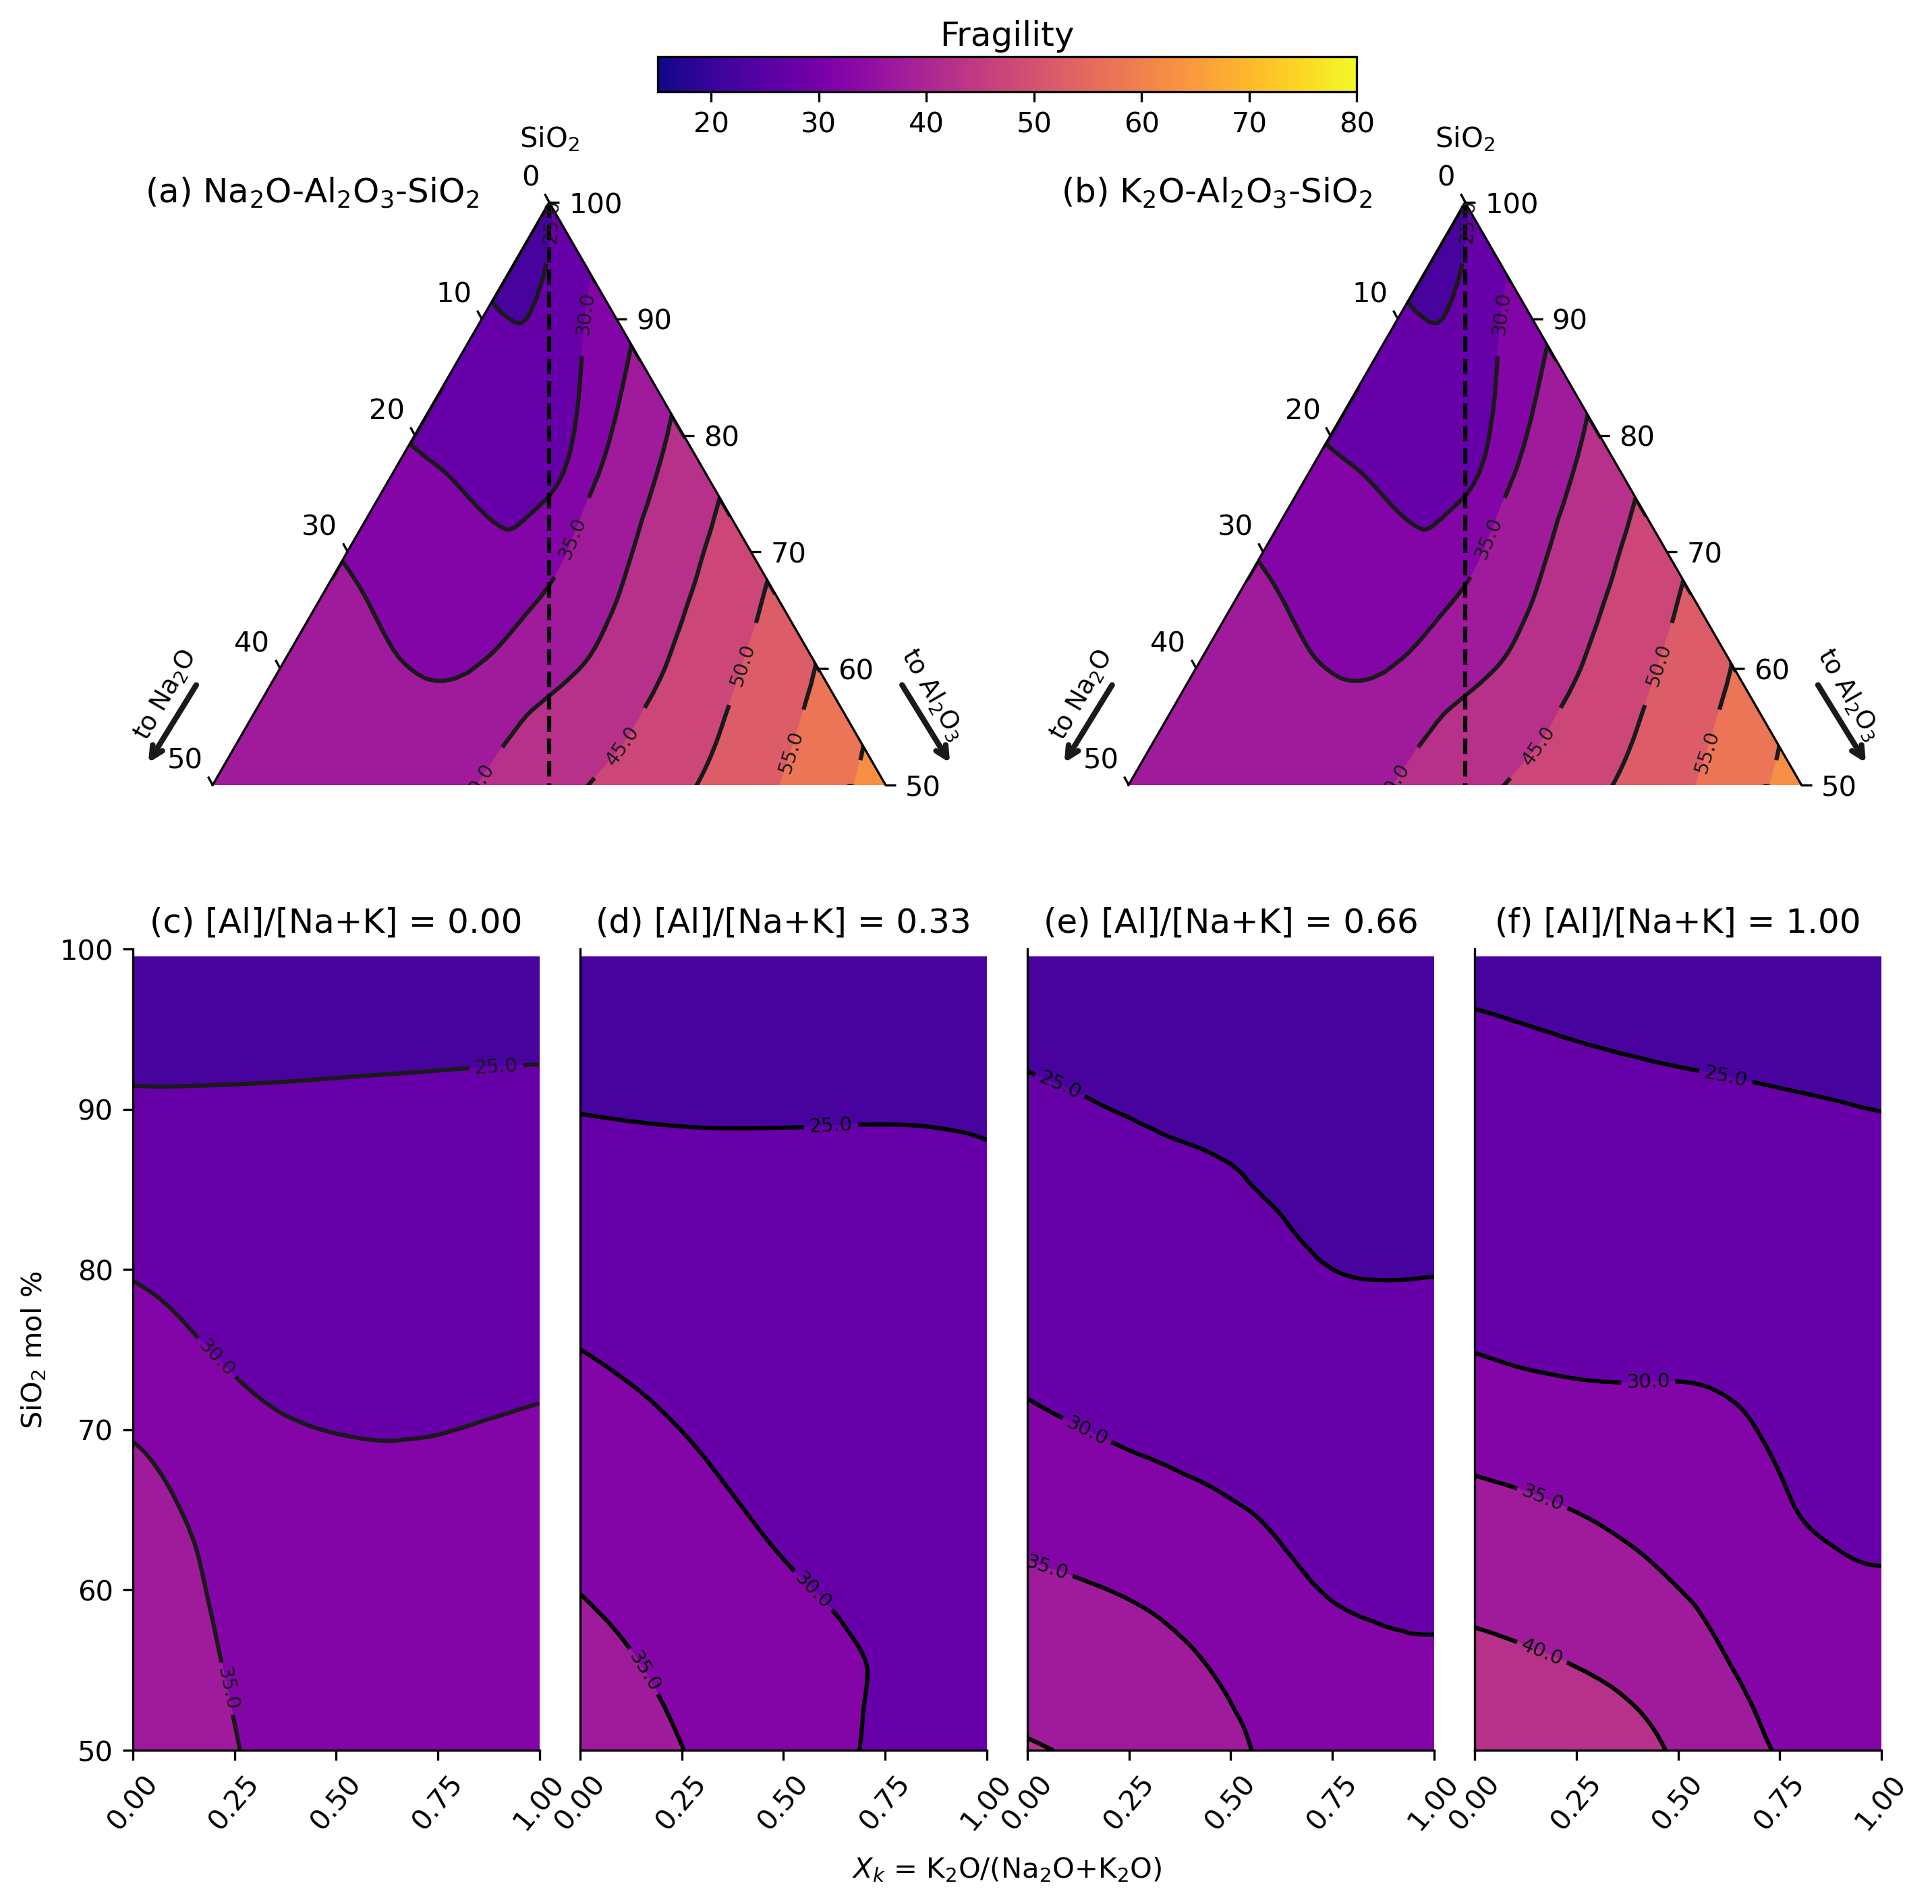

In [24]:
#APV: Added lines to contour plots for clarity
#     Increased levels for smoothness
#     Minor tweaks to layout
#     Wonder if colourbar limits should be changed to be integers for better labeling?

####
#### GENERATING ENTROPY
####

# grabing the entropies along NS/KS
fragility_NAS = neuralmodel.predict("fragility",X_gen_NAS).mean(axis=1)
fragility_KAS = neuralmodel.predict("fragility",X_gen_KAS).mean(axis=1)
fragility_all = neuralmodel.predict("fragility",X_gen_all).mean(axis=1)

# grabing the entropies for the mixtures
fragility_RS_Xk = neuralmodel.predict("fragility",X_gen_RS_Xk_rec.loc[:,["sio2","al2o3","na2o","k2o"]].values).mean(axis=1)
fragility_R3_Xk = neuralmodel.predict("fragility",X_gen_R3_Xk_rec.loc[:,["sio2","al2o3","na2o","k2o"]].values).mean(axis=1)
fragility_R2_Xk = neuralmodel.predict("fragility",X_gen_R2_Xk_rec.loc[:,["sio2","al2o3","na2o","k2o"]].values).mean(axis=1)
fragility_R1_Xk = neuralmodel.predict("fragility",X_gen_R1_Xk_rec.loc[:,["sio2","al2o3","na2o","k2o"]].values).mean(axis=1)

####
#### COLOR CALCULATIONS
####

trig_color_plot = fragility_all # for the colors > same scale 

# norm is a class which, when called, can normalize data into the
# [0.0, 1.0] interval.
norm = matplotlib.colors.Normalize(
    vmin=15.0,
    vmax=80.0) # Manual setup

c_m = matplotlib.cm.plasma # choose a colormap
s_m = matplotlib.cm.ScalarMappable(cmap=c_m, norm=norm) # create a ScalarMappable and initialize a data structure

####
#### FIGURE DECLARATION
#### gridspec is used for a finer control
####

fig11 = plt.figure(figsize=(9,9),dpi=300, constrained_layout=False)

gs1 = fig11.add_gridspec(nrows=1, ncols=2, 
                        left=0.02, right=0.98,
                        bottom = 0.55, top = 0.95,
                        wspace=0.1)
ax = fig11.add_subplot(gs1[0],projection='ternary',ternary_scale = 100)
ax2 = fig11.add_subplot(gs1[1],projection='ternary', ternary_scale = 100)

gs2 = fig11.add_gridspec(nrows=1, ncols=4, 
                        left=0.02, right=0.98,
                        bottom = 0.02, top = 0.46,
                        wspace=0.1)
ax3 = fig11.add_subplot(gs2[0,0])
ax5 = fig11.add_subplot(gs2[0,1])
ax6 = fig11.add_subplot(gs2[0,2])
ax4 = fig11.add_subplot(gs2[0,3])

####
#### TERNARY PLOT NAS
####
levels = np.arange(15,80,5)
levels_l = np.arange(15,80,5)

make_ternary(ax, 
             X_gen_NAS_rec.sio2, X_gen_NAS_rec.na2o, X_gen_NAS_rec.al2o3,fragility_NAS,
             'SiO$_2$', 'to Na$_2$O', 'to Al$_2$O$_3$',
            levels, levels_l, c_m, norm,
             [50,100],
            annotation = "(a) Na$_2$O-Al$_2$O$_3$-SiO$_2$")

####
#### TERNARY PLOT KAS
####

make_ternary(ax2, 
             X_gen_KAS_rec.sio2, X_gen_KAS_rec.k2o, X_gen_KAS_rec.al2o3,fragility_NAS,
             'SiO$_2$', 'to K$_2$O', 'to Al$_2$O$_3$',
            levels, levels_l, c_m, norm,
             [50,100],
            annotation = "(b) K$_2$O-Al$_2$O$_3$-SiO$_2$")

####
#### XK along near tectosilicate joint
####

tc3 = ax3.tricontourf(X_gen_RS_Xk_rec.loc[:,"xk"], 
                X_gen_RS_Xk_rec.loc[:,"sio2"]*100, 
                fragility_RS_Xk, 
                levels=levels, cmap=c_m, norm=norm)
tc3_l = ax3.tricontour(X_gen_RS_Xk_rec.loc[:,"xk"], 
                X_gen_RS_Xk_rec.loc[:,"sio2"]*100, 
                fragility_RS_Xk, 
                levels=levels_l, colors='k', norm=norm)
ax3.clabel(tc3_l, inline=1, fontsize=7, fmt="%1.1f")

ax3.set_xlim(0,1)
ax3.set_ylim(50,100.)

ax3.set_ylabel(r"SiO$_2$ mol %")

# Hide the right and top spines
ax3.spines['right'].set_visible(False)
ax3.spines['top'].set_visible(False)

# Title
ax3.set_title("(c) [Al]/[Na+K] = 0.00", loc='center')

####
#### XK along near join 3
####

tc5 = ax5.tricontourf(X_gen_R3_Xk_rec.loc[:,"xk"], 
                X_gen_R3_Xk_rec.loc[:,"sio2"]*100, 
                fragility_R3_Xk, 
                levels=levels, cmap=c_m, norm=norm)
tc5_l = ax5.tricontour(X_gen_R3_Xk_rec.loc[:,"xk"], 
                X_gen_R3_Xk_rec.loc[:,"sio2"]*100, 
                fragility_R3_Xk, 
                levels=levels_l, colors='black', norm=norm)
ax5.clabel(tc5_l, inline=1, fontsize=7, fmt="%1.1f")

ax5.set_xlim(0,1.)
ax5.set_ylim(50,100.)

# Hide the right and top spines
ax5.spines['right'].set_visible(False)
ax5.spines['top'].set_visible(False)

# Title
ax5.set_title("(d) [Al]/[Na+K] = 0.33", loc='center')

####
#### XK along near join 2
####
tc6 = ax6.tricontourf(X_gen_R2_Xk_rec.loc[:,"xk"], 
                X_gen_R2_Xk_rec.loc[:,"sio2"]*100, 
                fragility_R2_Xk, 
                levels=levels, cmap=c_m, norm=norm)
tc6_l = ax6.tricontour(X_gen_R2_Xk_rec.loc[:,"xk"], 
                X_gen_R2_Xk_rec.loc[:,"sio2"]*100, 
                fragility_R2_Xk, 
                levels=levels_l, colors='black', norm=norm)
ax6.clabel(tc6_l, inline=1, fontsize=7, fmt="%1.1f")

ax6.set_xlim(0,1.)
ax6.set_ylim(50,100.)

# Hide the right and top spines
ax6.spines['right'].set_visible(False)
ax6.spines['top'].set_visible(False)

# Title
ax6.set_title("(e) [Al]/[Na+K] = 0.66", loc='center')

####
#### XK along near tectosilicate joint
####

tc4 = ax4.tricontourf(X_gen_R1_Xk_rec.loc[:,"xk"], 
                X_gen_R1_Xk_rec.loc[:,"sio2"]*100, 
                fragility_R1_Xk, 
                levels=levels, cmap=c_m, norm=norm)
tc4 = ax4.tricontour(X_gen_R1_Xk_rec.loc[:,"xk"], 
                X_gen_R1_Xk_rec.loc[:,"sio2"]*100, 
                fragility_R1_Xk, 
                levels=levels_l, colors='black', norm=norm)

ax4.clabel(tc4, inline=1, fontsize=7, fmt="%1.1f")

ax4.set_xlim(0,1.)
ax4.set_ylim(50,100.)

# Hide the right and top spines
ax4.spines['right'].set_visible(False)
ax4.spines['top'].set_visible(False)

# Title
ax4.set_title("(f) [Al]/[Na+K] = 1.00", loc='center')

####
#### Layout adjustment ; most things are done above in gridspec so no need to add tight_layout()
####

# remove y ticks on bottom subplots
ax4.set_yticks([])
ax5.set_yticks([])
ax6.set_yticks([])

# rotate xticks
plt.setp(ax4.xaxis.get_majorticklabels(), rotation=50 )
plt.setp(ax5.xaxis.get_majorticklabels(), rotation=50 )
plt.setp(ax6.xaxis.get_majorticklabels(), rotation=50 )
plt.setp(ax3.xaxis.get_majorticklabels(), rotation=50 )

# common X labels
fig11.text(0.5, -0.05, r"$X_k$ = K$_2$O/(Na$_2$O+K$_2$O)", ha='center')

####
#### colorbar
####

cbar_0 = plt.colorbar(mappable=s_m, ax=[ax,ax2],shrink=0.4,location='top',anchor=(0.5,1.0))
cbar_0.set_label(r"Fragility", fontsize=12)
cbar_0.ax.xaxis.set_label_position('top')
cbar_0.ax.xaxis.set_ticks_position('bottom')

plt.savefig("./figures/Figure12_Fragility.pdf",bbox_inches="tight")


# Figure 13: maps of glass properties: Tg, density, refractive index

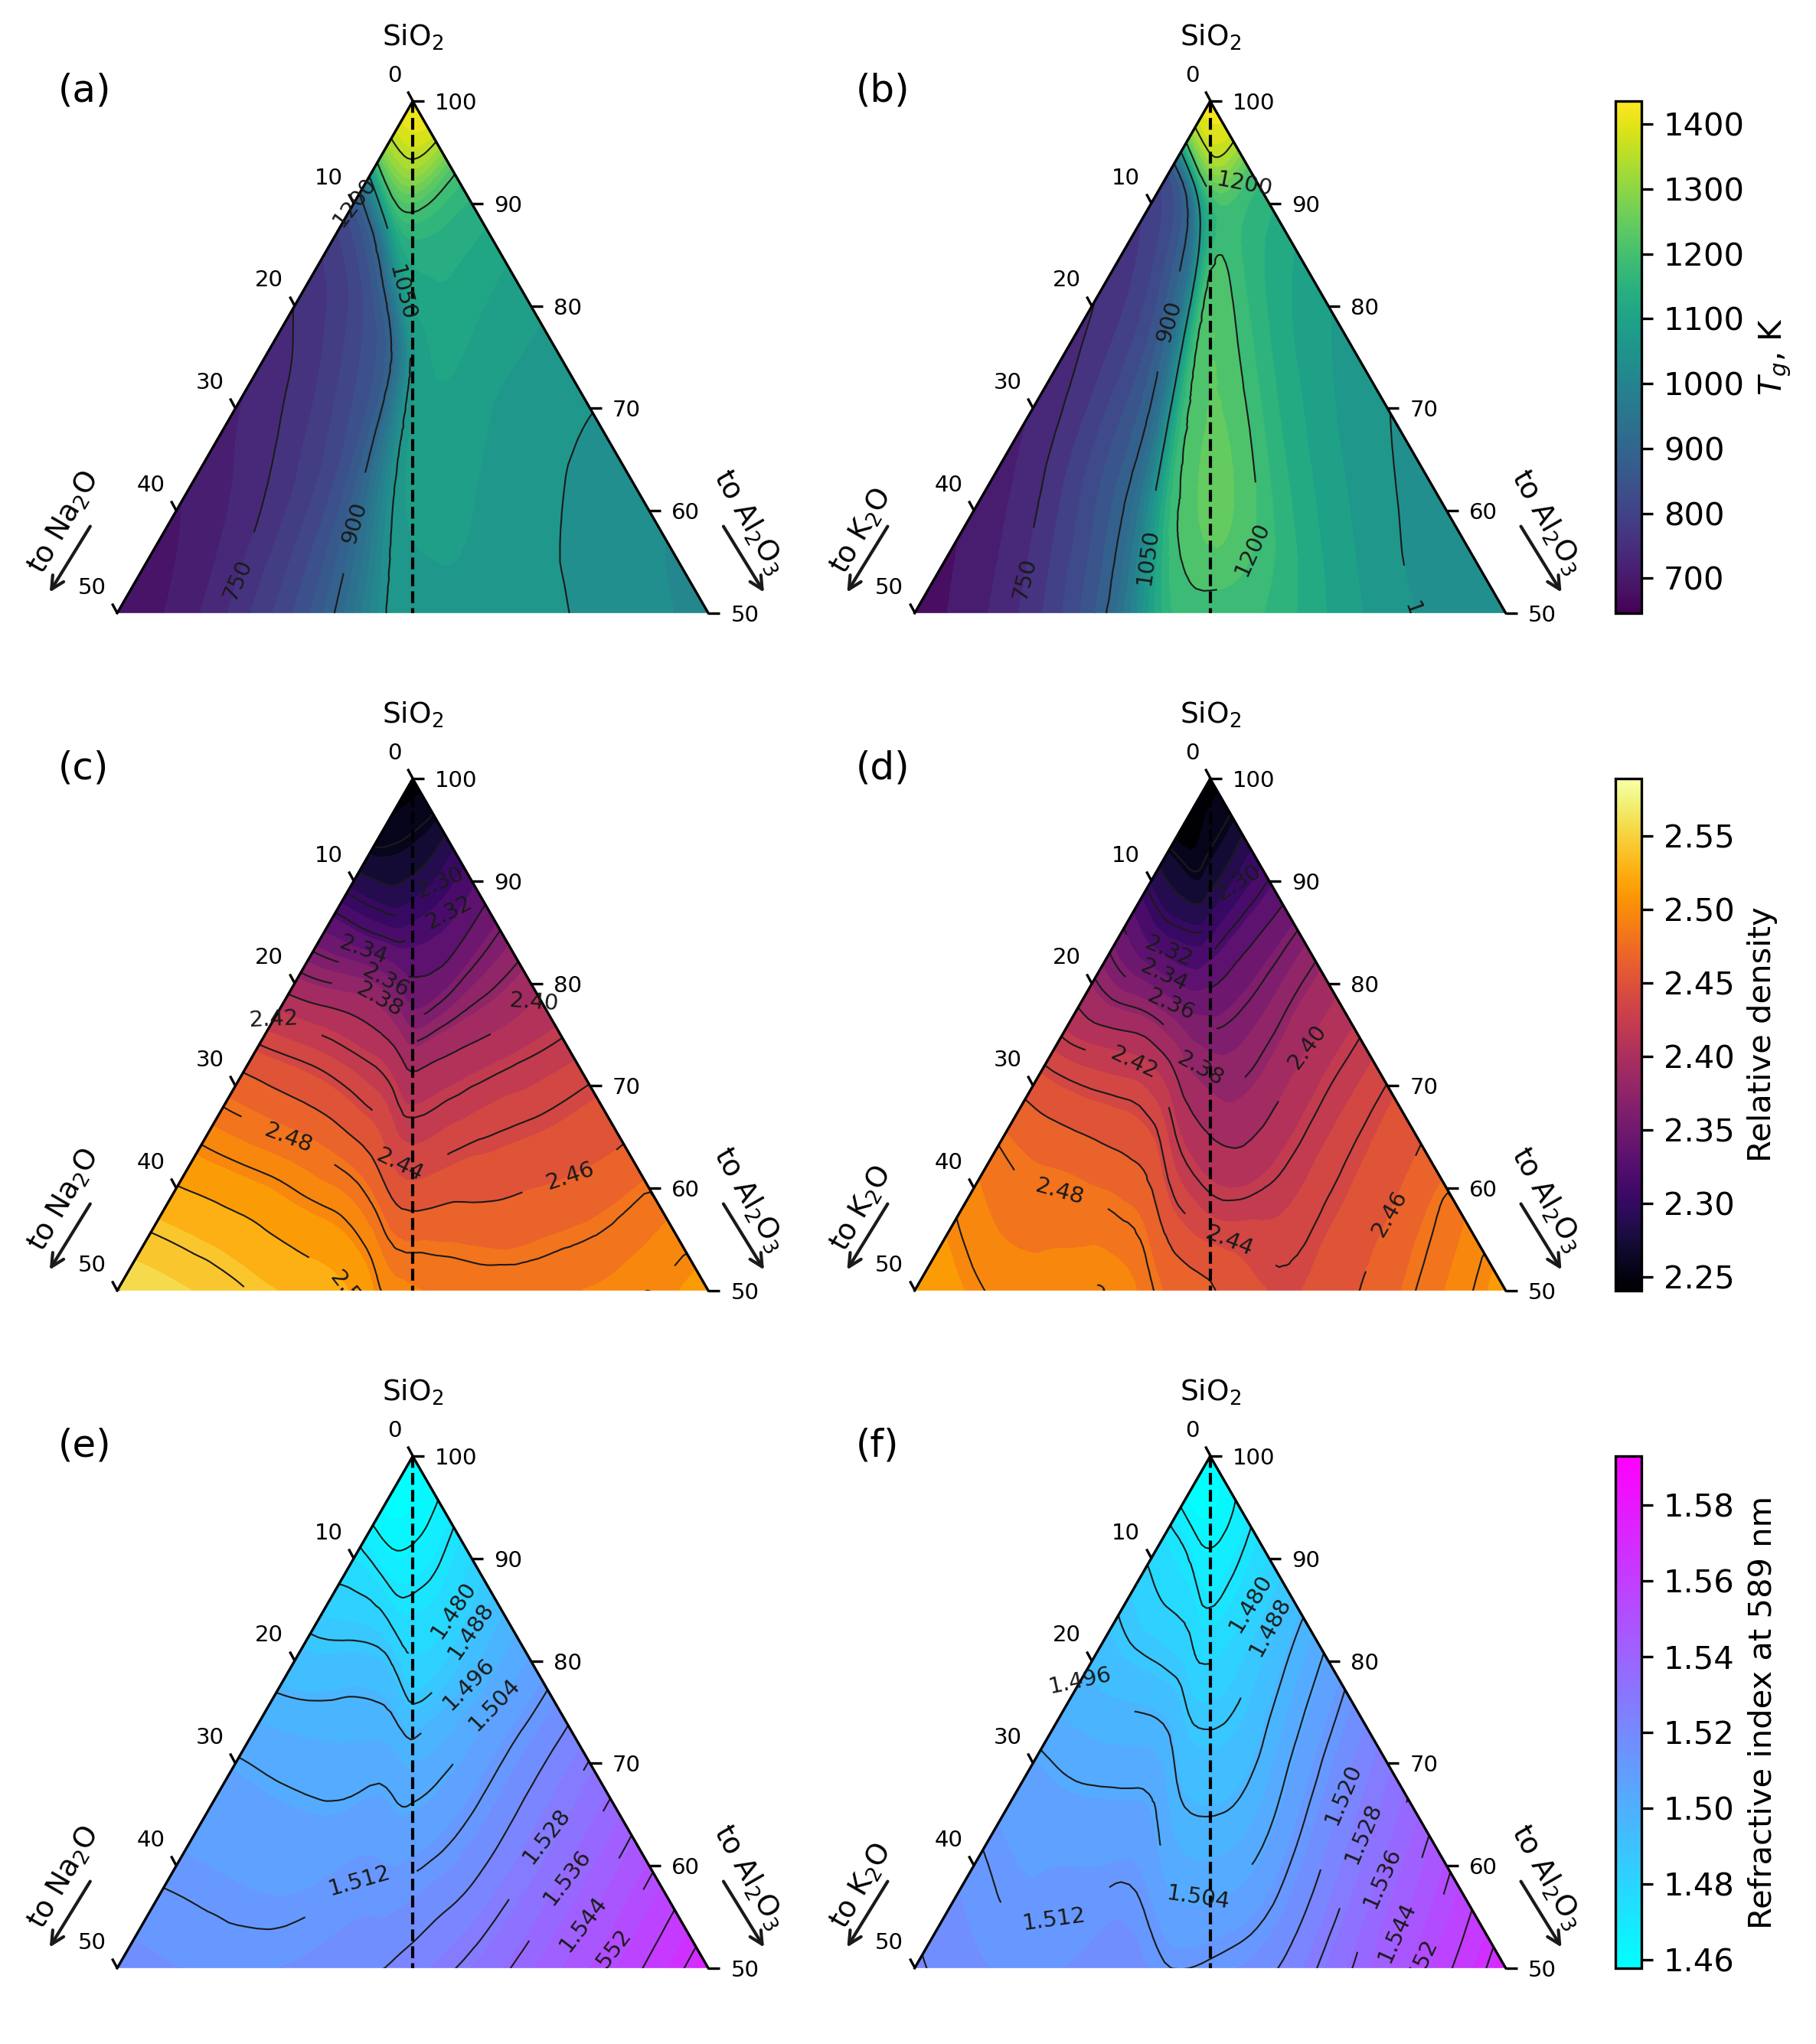

In [25]:
plt.figure(figsize=(9,9), dpi=300)

# grabing the predictions in NAS and KAS
tg_NAS = neuralmodel.predict("tg",X_gen_NAS).mean(axis=1)
tg_KAS = neuralmodel.predict("tg",X_gen_KAS).mean(axis=1)
tg_all = neuralmodel.predict("tg",X_gen_all).mean(axis=1)

d_NAS = neuralmodel.predict("density",X_gen_NAS).mean(axis=1)
d_KAS = neuralmodel.predict("density",X_gen_KAS).mean(axis=1)
d_all = neuralmodel.predict("density",X_gen_all).mean(axis=1)

n_NAS = neuralmodel.predict("sellmeier",X_gen_NAS,lbd=np.ones((len(X_gen_NAS),1))*0.589).mean(axis=1)
n_KAS = neuralmodel.predict("sellmeier",X_gen_KAS,lbd=np.ones((len(X_gen_KAS),1))*0.589).mean(axis=1)
n_all = neuralmodel.predict("sellmeier",X_gen_all,lbd=np.ones((len(X_gen_all),1))*0.589).mean(axis=1)

# choose colormaps
c_m1 = matplotlib.cm.viridis 
c_m2 = matplotlib.cm.inferno 
c_m3 = matplotlib.cm.cool 

# color normalisation
norm1 = matplotlib.colors.Normalize(vmin=np.min(tg_all), vmax=np.max(tg_all))
norm2 = matplotlib.colors.Normalize(vmin=np.min(d_all), vmax=np.max(d_all))
norm3 = matplotlib.colors.Normalize(vmin=np.min(n_all), vmax=np.max(n_all))

#### Scalar Mappables for color bars
s_tg = matplotlib.cm.ScalarMappable(cmap=c_m1, 
                                   norm=norm1) # create a ScalarMappable and initialize a data structure
s_d = matplotlib.cm.ScalarMappable(cmap=c_m2, 
                                   norm=norm2)
s_n = matplotlib.cm.ScalarMappable(cmap=c_m3, 
                                   norm=norm3)

#### Levels

levels_tg = np.arange(500,1500,100)
levels_tg_write = [700, 900, 1100]
levels_d = np.arange(2.2,2.8,0.02)
levels_n = np.arange(1.3,1.9,0.01)

####
#### NAS Tg TERNARY PLOT
####
ax = plt.subplot(3,2,1,projection='ternary', ternary_scale=100)

tc = ax.tricontourf(X_gen_NAS_rec.sio2,X_gen_NAS_rec.na2o,X_gen_NAS_rec.al2o3, 
                tg_NAS, 
                levels=30, cmap=c_m1, norm=norm1)

tc = ax.tricontour(X_gen_NAS_rec.sio2,X_gen_NAS_rec.na2o,X_gen_NAS_rec.al2o3, 
                tg_NAS, 
                levels=6, colors="k", norm=norm1, linewidths=0.5)

ax.clabel(tc, inline=1, fontsize=7, fmt="%1.0f")

ax.set_tlabel('SiO$_2$', fontsize = 9)
make_arrow(ax, 'to Na$_2$O', 'to Al$_2$O$_3$', sx1 = -0.12, sx2 = 1.02, fontsize = 9, linewidth=1.)
ax.tick_params(labelrotation='horizontal')

####
#### KAS Tg TERNARY PLOT
####
ax2 = plt.subplot(3,2,2,projection='ternary', ternary_scale=100)

tc2 = ax2.tricontourf(X_gen_KAS_rec.sio2,X_gen_KAS_rec.k2o,X_gen_KAS_rec.al2o3, 
                tg_KAS, 
                levels=30, cmap=c_m1, norm=norm1)

tc2 = ax2.tricontour(X_gen_KAS_rec.sio2,X_gen_KAS_rec.k2o,X_gen_KAS_rec.al2o3, 
                tg_KAS, 
                levels=6, colors="k", norm=norm1, linewidths=0.5)

ax2.clabel(tc2, inline=1, fontsize=7, fmt="%1.0f")

ax2.set_tlabel('SiO$_2$', fontsize = 9)
make_arrow(ax2, 'to K$_2$O', 'to Al$_2$O$_3$', sx1 = -0.12, sx2 = 1.02, fontsize = 9, linewidth=1.)
ax2.tick_params(labelrotation='horizontal')

####
#### NAS Density TERNARY PLOT
####
ax3 = plt.subplot(3,2,3,projection='ternary', ternary_scale=100)

ax3.tricontourf(X_gen_NAS_rec.sio2,X_gen_NAS_rec.na2o,X_gen_NAS_rec.al2o3, 
                d_NAS, 
                levels=30, cmap=c_m2, norm=norm2)

tc3 = ax3.tricontour(X_gen_NAS_rec.sio2,X_gen_NAS_rec.na2o,X_gen_NAS_rec.al2o3, 
                d_NAS, 
                levels=levels_d, colors="k", norm=norm2, linewidths=0.5)

ax3.clabel(tc3, inline=1, fontsize=7, fmt="%1.2f")

ax3.set_tlabel('SiO$_2$', fontsize = 9)
make_arrow(ax3, 'to Na$_2$O', 'to Al$_2$O$_3$', sx1 = -0.12, sx2 = 1.02, fontsize = 9, linewidth=1.)
ax3.tick_params(labelrotation='horizontal')

####
#### KAS Density TERNARY PLOT
####
ax4 = plt.subplot(3,2,4,projection='ternary', ternary_scale=100)

ax4.tricontourf(X_gen_KAS_rec.sio2,X_gen_KAS_rec.k2o,X_gen_KAS_rec.al2o3, 
                d_KAS, 
                levels=30, cmap=c_m2, norm=norm2)

tc4 = ax4.tricontour(X_gen_KAS_rec.sio2,X_gen_KAS_rec.k2o,X_gen_KAS_rec.al2o3, 
                d_KAS, 
                levels=levels_d, colors="k", norm=norm2, linewidths=0.5)

ax4.clabel(tc4, inline=1, fontsize=7, fmt="%1.2f")

ax4.set_tlabel('SiO$_2$', fontsize = 9)
make_arrow(ax4, 'to K$_2$O', 'to Al$_2$O$_3$', sx1 = -0.12, sx2 = 1.02, fontsize = 9, linewidth=1.)
ax4.tick_params(labelrotation='horizontal')

####
#### NAS Refractive Index TERNARY PLOT
####
ax5 = plt.subplot(3,2,5,projection='ternary', ternary_scale=100)

# data are plotted
ax5.tricontourf(X_gen_NAS_rec.sio2,X_gen_NAS_rec.na2o,X_gen_NAS_rec.al2o3, 
                n_NAS, 
                levels=30, cmap=c_m3, norm=norm3)

tc5 = ax5.tricontour(X_gen_NAS_rec.sio2,X_gen_NAS_rec.na2o,X_gen_NAS_rec.al2o3, 
                n_NAS, 
                levels=20, colors="k", norm=norm3, linewidths=0.5)
ax5.clabel(tc5, inline=1, fontsize=7, fmt="%1.3f")

ax5.set_tlabel('SiO$_2$', fontsize = 9)
make_arrow(ax5, 'to Na$_2$O', 'to Al$_2$O$_3$', sx1 = -0.12, sx2 = 1.02, fontsize = 9, linewidth=1.)
ax5.tick_params(labelrotation='horizontal')

####
#### KAS Refractive Index TERNARY PLOT
####
ax6 = plt.subplot(3,2,6,projection='ternary', ternary_scale=100)

# data are plotted
ax6.tricontourf(X_gen_KAS_rec.sio2,X_gen_KAS_rec.k2o,X_gen_KAS_rec.al2o3, 
                n_KAS, 
                levels=30, cmap=c_m3, norm=norm3)

tc6 = ax6.tricontour(X_gen_KAS_rec.sio2,X_gen_KAS_rec.k2o,X_gen_KAS_rec.al2o3, 
                n_KAS, 
                levels=20, colors="k", norm=norm3, linewidths=0.5)

ax6.clabel(tc6, inline=1, fontsize=7, fmt="%1.3f")

ax6.set_tlabel('SiO$_2$', fontsize = 9)
make_arrow(ax6, 'to K$_2$O', 'to Al$_2$O$_3$', sx1 = -0.12, sx2 = 1.02, fontsize = 9, linewidth=1.)
ax6.tick_params(labelrotation='horizontal')

####
#### Limits (see previous examples)
#### tmin, tmax, lmin, lmax, rmin, rmax
####
ax.set_ternary_lim(50, 100, 0.0, 50,0.0, 50)
ax2.set_ternary_lim(50, 100, 0.0, 50,0.0, 50)
ax3.set_ternary_lim(50, 100, 0.0, 50,0.0, 50)
ax4.set_ternary_lim(50, 100, 0.0, 50,0.0, 50)
ax5.set_ternary_lim(50, 100, 0.0, 50,0.0, 50)
ax6.set_ternary_lim(50, 100, 0.0, 50,0.0, 50)

####
#### Annotations
####
ax.annotate("(a)", xy=(-0.1,1.0), xycoords="axes fraction", fontsize=12)
ax2.annotate("(b)", xy=(-0.1,1.0), xycoords="axes fraction", fontsize=12)
ax3.annotate("(c)", xy=(-0.1,1.0), xycoords="axes fraction", fontsize=12)
ax4.annotate("(d)", xy=(-0.1,1.0), xycoords="axes fraction", fontsize=12)
ax5.annotate("(e)", xy=(-0.1,1.0), xycoords="axes fraction", fontsize=12)
ax6.annotate("(f)", xy=(-0.1,1.0), xycoords="axes fraction", fontsize=12)

####
#### ticks size
####
ax.tick_params(labelsize=7)
ax2.tick_params(labelsize=7)
ax3.tick_params(labelsize=7)
ax4.tick_params(labelsize=7)
ax5.tick_params(labelsize=7)
ax6.tick_params(labelsize=7)

ax.raxis.set_ticks([])
ax2.raxis.set_ticks([])
ax3.raxis.set_ticks([])
ax4.raxis.set_ticks([])
ax5.raxis.set_ticks([])
ax6.raxis.set_ticks([])

###
### plot tectosilicate join
###
ax.plot([1.0,0.5],[0.,0.5],[0.,0.5],"--",color="black",linewidth=1)
ax2.plot([1.0,0.5],[0.,0.5],[0.,0.5],"--",color="black",linewidth=1)
ax3.plot([1.0,0.5],[0.,0.5],[0.,0.5],"--",color="black",linewidth=1)
ax4.plot([1.0,0.5],[0.,0.5],[0.,0.5],"--",color="black",linewidth=1)
ax5.plot([1.0,0.5],[0.,0.5],[0.,0.5],"--",color="black",linewidth=1)
ax6.plot([1.0,0.5],[0.,0.5],[0.,0.5],"--",color="black",linewidth=1)

####
#### Remove bottom axis
####
ax.spines['tside'].set_visible(False)
ax2.spines['tside'].set_visible(False)
ax3.spines['tside'].set_visible(False)
ax4.spines['tside'].set_visible(False)
ax5.spines['tside'].set_visible(False)
ax6.spines['tside'].set_visible(False)


####
#### tight layout
####

plt.tight_layout(w_pad=1.)

####
#### Colorbar for the two subplots
####
cbar_1 = plt.colorbar(mappable=s_tg,ax=[ax,ax2],orientation="vertical",pad=0.055)
cbar_1.set_label(r"$T_g$, K")

cbar_2 = plt.colorbar(mappable=s_d,ax=[ax3,ax4],orientation="vertical",pad=0.055)
cbar_2.set_label(r"Relative density")

cbar_3 = plt.colorbar(mappable=s_n,ax=[ax5,ax6],orientation="vertical",pad=0.055)
cbar_3.set_label(r"Refractive index at 589 nm")


plt.savefig("./figures/Figure13_Tg_maps.pdf",bbox_inches='tight')

# Figure 14 : eruptive dynamic, and mapping of entropy and structure

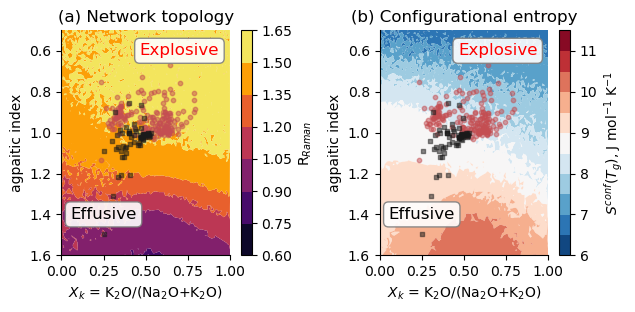

In [26]:
# Loading the data from Di Genova 2017
# the spreadsheet was modified a minimum to be loaded by Pandas
dataset_DG2017 = pd.read_excel("./data/dev/nature24488-s2-modified.xlsx")
dataset_DG2017.head()

# we group data by location
dataset_DG2017 = dataset_DG2017.groupby('Location').mean().reset_index()

# generating many simplified rhyolite compositions to calculate their properties and map them
nb_samples = 10000

X_rh = pd.DataFrame()
X_rh["sio2"] = np.random.random_sample(nb_samples)*0.04 + 0.78

R_MAl = np.random.random_sample(nb_samples)*0.4 + 0.3 # ratio of alkalis to Al
R_XK = np.random.random_sample(nb_samples) # ratio K/(K+Na)

X_rh["al2o3"] = (1.0 - R_MAl)*(1-X_rh["sio2"])
X_rh["na2o"] = (1-X_rh["sio2"]-X_rh["al2o3"])*(1-R_XK)
X_rh["k2o"] = (1-X_rh["sio2"]-X_rh["al2o3"]-X_rh["na2o"])

rh_sctg = neuralmodel.predict("sctg",torch.Tensor(X_rh.values).to(device)).mean(axis=1).reshape(-1,1)
rh_be = neuralmodel.predict("be",torch.Tensor(X_rh.values).to(device)).mean(axis=1).reshape(-1,1)

Raman_rh = neuralmodel.predict("raman_pred",X_rh.values).mean(axis=2)

Rr_rh = np.trapz(Raman_rh[:,x_raman_shift<670],x_raman_shift[x_raman_shift<670],axis=1)/np.trapz(Raman_rh[:,x_raman_shift>860],x_raman_shift[x_raman_shift>860],axis=1)

#
# WHAT DO WE PLOT?
#

plotted_structure = Rr_rh.reshape(-1)
plotted_entropy = neuralmodel.predict("sctg",torch.Tensor(X_rh.values).to(device)).mean(axis=1).reshape(-1,1)


#
# FIGURE
#

fig4, ax = plt.subplots(1,2,figsize=(6.44,3.22))

bbox_props = dict(boxstyle="round", fc="w", ec="0.5", alpha=0.9)

#
# SUBPLOT 1
#
ax1 = ax[0]

# MODEL
tc1 = ax1.tricontourf(X_rh.loc[:,"k2o"]/(X_rh.loc[:,"na2o"]+X_rh.loc[:,"k2o"]),
                (X_rh.loc[:,"na2o"]+X_rh.loc[:,"k2o"])/(X_rh.loc[:,"al2o3"]), 
                plotted_structure.reshape(-1), 
                levels=7, cmap="inferno",antialiased=True)

cbar = fig4.colorbar(tc1, ax=ax1)

cbar.set_label('R$_{Raman}$')

# DATA
ax1.scatter(dataset_DG2017.loc[dataset_DG2017["Explo"]==1,"K#"],
            np.abs(dataset_DG2017.loc[dataset_DG2017["Explo"]==1,"RAI"]),c='r',marker="o",s=10,alpha=0.5,label="Explosif")
ax1.scatter(dataset_DG2017.loc[dataset_DG2017["Explo"]==0,"K#"],
            np.abs(dataset_DG2017.loc[dataset_DG2017["Explo"]==0,"RAI"]),c='k',marker="s",s=10,alpha=0.5,label="Dôme")

ax1.text(0.7,0.6, "Explosive", ha="center", va="center", size=12, color="red",
        bbox=bbox_props)

ax1.text(0.25, 1.4, "Effusive", ha="center", va="center", size=12, color="black",
        bbox=bbox_props)

ax1.set_xlabel(r"$X_k$ = K$_2$O/(Na$_2$O+K$_2$O)")
ax1.set_ylabel(r"agpaitic index")
ax1.set_xlim(0,1)
ax1.set_ylim(1.6,0.5)

# Hide the right and top spines
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)

#
# SUBPLOT 2
#
ax2 = ax[1]

# MODEL
tc2 = ax2.tricontourf(X_rh.loc[:,"k2o"]/(X_rh.loc[:,"na2o"]+X_rh.loc[:,"k2o"]),
                (X_rh.loc[:,"na2o"]+X_rh.loc[:,"k2o"])/(X_rh.loc[:,"al2o3"]), 
                plotted_entropy.reshape(-1), 
                levels=11, cmap="RdBu_r",antialiased=True)

# Now adding the colorbar and its label
cbar2 = plt.colorbar(mappable=tc2, ax=ax2)
cbar2.set_label('$S^{conf}(T{_g})$, J mol$^{-1}$ K$^{-1}$')

# DATA
ax2.scatter(dataset_DG2017.loc[dataset_DG2017["Explo"]==1,"K#"],
            np.abs(dataset_DG2017.loc[dataset_DG2017["Explo"]==1,"RAI"]),c='r',marker="o",s=10,alpha=0.5,label="Explosif")
ax2.scatter(dataset_DG2017.loc[dataset_DG2017["Explo"]==0,"K#"],
            np.abs(dataset_DG2017.loc[dataset_DG2017["Explo"]==0,"RAI"]),c='k',marker="s",s=10,alpha=0.5,label="Dôme")

#ax2.annotate("Effusive", xy=(0.1,0.31),xycoords="axes fraction",color="black",fontsize=12)
#x2.annotate("Explosive", xy=(0.5,0.85),xycoords="axes fraction",color="red",fontsize=12)

ax2.text(0.7,0.6, "Explosive", ha="center", va="center", size=12, color="red",
        bbox=bbox_props)

ax2.text(0.25, 1.4, "Effusive", ha="center", va="center", size=12, color="black",
        bbox=bbox_props)

ax2.set_xlabel(r"$X_k$ = K$_2$O/(Na$_2$O+K$_2$O)")
ax2.set_ylabel(r"agpaitic index")
ax2.set_xlim(0,1)
ax2.set_ylim(1.6,0.5)

# Hide the right and top spines
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)

ax1.set_title("(a) Network topology")
ax2.set_title("(b) Configurational entropy")

plt.tight_layout()

plt.savefig('./figures/Figure14_agpaitic_entropy.pdf')